<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# [Sc√©narios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

# Projet 4 A MACHINE LEARNING EN PYTHON

**R√©sum√©**: Exploration puis mod√©lisation de donn√©es climatiques en utilisant Python et la librairie [Scikit-learn](http://scikit-learn.org/stable/#). L'objectif est de pr√©voir pour le lendemain un possible d√©passement d'un seuil de concentration en ozone √† partir d'une pr√©vision d√©terministe sur un maillage grossier et de variables climatiques locales. Estimation par diff√©rentes m√©thodes: r√©gression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [k plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de d√©cision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agr√©gation de mod√®le](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de pr√©vision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un √©chantillon test puis des courbes ROC. It√©ration sur plusieurs √©chantillons tests pour analyser la distribution de l'erreur de pr√©vision. Ce calepin vient compl√©ter l'[√©tude faite avec R](http://www.math.univ-toulouse.fr/~besse/Wikistat/Notebooks/Notebook-R-Ozone.html) pour en comparer les deux approches.

**Avertissement** 

* Ce calepin compl√®te [celui en R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) afin de comparer les performances respectives des deux environnements: compl√©tude des r√©sultats et efficacit√© du code. Les explications sont plus sommaires dans ce tutoriel qui est en principe ex√©cut√© *apr√®s* ou parall√®lement √† celui r√©alis√© en R.  
* Comme pour R il est *d√©coup√© en 5 s√©ances* de travaux dirig√©s *syncronis√©es* avec le cours d'apprentissage automatique. 
* R√©fl√©chir aux r√©ponses aux questions marqu√©es **Q** issues du sujet d'examen.
* Toutes les options n'ont pas √©t√© test√©es et certaines sont pos√©es en **exercice**.

## Introduction

<FONT COLOR="Red"> Pour la REGRESSION : au lieu d'utiliser la norme $L^2$ pour le calcul du MSE, pour l'erreur de g√©n√©ralisation, on peut utiliser ce que m√©t√©o France utilise i.e MAPE=$\frac{100}{n} \sum_{i=1}^{n} \frac{|Y_i-\hat{Y}_i|}{Y_i+1}$ FAIRE ATTENTION !

In [243]:
def MAPE(y_true, y_pred) : #fonction propre √† m√©t√©o france, permettant de calculer le MSE dans notre cas 
    n = len(y_true) 
    res = 0
    for i in range(n) :
        res += np.abs(y_true[i]-y_pred[i])/(y_true[i]+1)
    return res*(100/n)

In [244]:
def purity(crosstab): #fonction prenant une table de contingence en entr√©e et calculant la puret√©, propre √† la classification
    cross=crosstab.to_numpy()
    purity = 0.
    for cluster in range(cross.shape[1]):  # clusters are along columns
        purity += np.max(cross[ cluster,:])
    return purity/np.sum(cross)

In [245]:
# fonction qui prend en entr√©e :
# - les pr√©dictions en regression (rain_reg) et en classification (rain_class)
# - les r√©sultats attendus pour les sets de test en classification (Yb_test)
# La fonction associe √† la pr√©diction en regression la classe de pluie correspondante puis calcule le 
# NMI et le score de Mallow. Les seuils sont : 
# - no_rain si rain = 0
# - low_rain si 0 < rain <= 2
# - high rain si rain > 2

from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import normalized_mutual_info_score 

def compare_reg_class(rain_reg, rain_class,Yb_test) : 
    rain_reg = np.array(rain_reg)
    rain_class = np.array(rain_class)
    rain_comp = np.array([''] * np.size(rain_reg), dtype="object") 
    ind_no = np.where(rain_reg==0)[0]
    ind_low =  list(set(np.where(rain_reg>0)[0])&set(np.where(rain_reg<=2)[0]))
    ind_high = np.where(rain_reg>2)[0]
    
    rain_comp[ind_no] = 'no_rain'
    rain_comp[ind_low] = 'low_rain'
    rain_comp[ind_high] = 'high_rain'
    
    #r√©sultat regression :
    NMIr = normalized_mutual_info_score(rain_comp,Yb_test)
    Mallowr = fowlkes_mallows_score(rain_comp,Yb_test)
    print('NMI regression : ', NMIr)
    print('Mallow regression : ', Mallowr)
    
    #r√©sultat classification : 
    NMIb = normalized_mutual_info_score(rain_class,Yb_test)
    Mallowb = fowlkes_mallows_score(rain_class,Yb_test)
    print('NMI classification : ', NMIb)
    print('Mallow classification : ', Mallowb)
    
    #comparaison des deux r√©sultats : 
    NMI = normalized_mutual_info_score(rain_comp,rain_class)
    Mallow = fowlkes_mallows_score(rain_comp,rain_class)
    print('NMI classification : ', NMI)
    print('Mallow classification : ', Mallow)
    
    return NMIr,Mallowr,NMIb,Mallowb,NMI,Mallow

# <FONT COLOR="Red">√âpisode 1</font>
<FONT COLOR="Red">02-09</font>

## Prise en compte des donn√©es

Pr√©sentation du jeu de donn√©es : La population √©tudi√©e dans ce jeu de donn√©es est l‚Äôensemble des observations m√©t√©orologiques d'une station de M√©t√©o France. Notre √©chantillon se compose de 688 observations, entre le 2 janvier 2016 et 30 d√©cembre 2017. Le jeu de donn√©es comprend 18 variables statistiques (dont 2 qualitatives et 16 quantitatives). Concernant les variables qualitatives, la date est qualitative ordinale avec 688 modalit√©s, la variable rain_class a 4 modalit√©s (1: high_rain, 2:low_rain, 3:no_rain). 

Les donn√©es ont √©t√© extraites et mises en forme par le service concern√© de M√©t√©o France. Elles sont d√©crites par les variables suivantes :

PARAMETRES METEOROLOGIQUES OBSERVES LE JOUR J:
* **date** : date du jour actuel ;
* **ff** : vitesse du vent (en $m.s^{-1}$);
* **t** :temp√©rature (en Kelvin K);
* **td** : point de ros√©e (en K) ;
* **hu** : l'humidit√© (en %);
* **dd** : direction du vent (en degr√©s) ;
* **precip** : quantit√© totale des pr√©cipitations ;

PREVISIONS METEOS DU JOUR SUIVANT :
* **ws_arome** : vitesse du vent (en $m.s^{-1}$);
* **p3031_arome** : direction du vent (en degr√©s);
* **u10_arome**: composantes du vent d'ouest √† est prise √† 10m de hauteur (en $m.s^{-1}$);
* **vu10_arome**:composantes du vent du sud au nord prise √† 10m de hauteur (en $m.s^{-1}$);
* **t2m_arome**: temp√©rature √† 2m√®tres du sol (K);
* **d2m_arome**: point de ros√©e √† 2m du sol(K);
* **r_arome**: humidit√© (en %) ;
* **tp_arome**: quantit√© totale de pr√©cipitations ($kg.m^{‚àí2}$);
* **msl_arome**: pression atmosph√©rique (en P a);

VARIABLES REPONSE
* **rain** : quantit√© totale de pr√©cipitation le jour suivant $kg.m^{‚àí2}$;
* **rain_class**: cat√©gorie de pr√©cipitations : -no_rain (si rain=0), -low_rain (si 0<rain<2), -high_rain (si rain>2)

## 1. Chargement et mise en forme des donn√©es

In [246]:
#!pip install "pydotplus"

In [247]:
#chargement des librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log
from pandas.plotting import scatter_matrix
#! pip install pyensae 
import pyensae
from pyensae.graphhelper import Corrplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from statsmodels.graphics.mosaicplot import mosaic #faire une mosaic
from pandas.plotting import scatter_matrix
from pyensae.graphhelper import Corrplot

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import scale
from sklearn.cluster  import  KMeans
from  sklearn.metrics  import confusion_matrix
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LassoLarsCV
from itertools import cycle

from sklearn.linear_model import lasso_path
from sklearn.linear_model import LogisticRegression
import statsmodels as sm

from sklearn.tree import export_graphviz
import six
from six import StringIO  
import pydotplus
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_predict, KFold
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

In [248]:
# Lecture des donn√©es
## Charger les donn√©es ou les lire directement en pr√©cisant le chemin
path=""
meteo=pd.read_csv("rain_project.txt",delimiter=" ",header=0)
del(meteo["Id"]) #supprimer la colonne Id
# V√©rification du contenu
meteo.head()

tparome_original=meteo["tp_arome"]
meteorain_original=meteo["rain"]

Ce qui suit permet d'affecter le bon type aux variables.

In [249]:
meteo["rain_class"]=pd.Categorical(meteo["rain_class"],ordered=False)
meteo.dtypes
meteo.date=pd.to_datetime(meteo.date)

print("date de d√©but", meteo["date"].min(), "date de fin", meteo["date"].max())
#meteo['month'] = meteo['date'].dt.month 
meteo["date"] = meteo["date"].dt.month_name() #transforme la valeur date en une variable mois 
#print(meteo.dtypes)

date de d√©but 2016-01-02 00:00:00 date de fin 2017-12-30 00:00:00


In [250]:
meteo.describe()
meteo.date

1          June
2         March
3          July
4           May
5      February
         ...   
726       April
727      August
728         May
729        June
730       April
Name: date, Length: 688, dtype: object

## 2. Analyse Unidimensionnelle

### Analyse propos√©e par th√®me :  

1. Imput :

- Les variables relatives √† la vitesse du vent (ff_mod, ws_arome_mod) 
- les variables relatives aux pr√©cipitations (precip_mod et tp_arome)
- Les variables relatives √† la temp√©rature et au point de ros√©e (t_mod, td_mod, t2m_arome_mod et d2m_arome_mod)
- Les variables relatives √† la direction du vent (dd_mod, p3031_arome_mod, u10_arome, v10_arome)
- Les variables relatives √† l'humidit√© (hu et r_arome)
- pression atmosph√©rique (msl arome)

2. Output : 

- rain et rain class 


Pour chaque variable 

- tracer histogramme (ou regarder ci-dessus mais c'est un peu petit) + fonction de r√©partition + boxplot

- ou pie chart et barplot si variable qualitative 

- donner une interpr√©tation de la distribution.

M√™me si les donn√©es ne pr√©sentent pas de d√©fauts particuliers, une √©tude exploratoire pr√©liminaire est indispensable afin de s'assurer le leur bonne coh√©rence, proposer d'√©ventuelles transformations et analyser les structures de corr√©lations ou plus g√©n√©ralement de liaisons entre les variables, de groupes des individus ou observations.

array([<AxesSubplot:ylabel='rain_class'>], dtype=object)

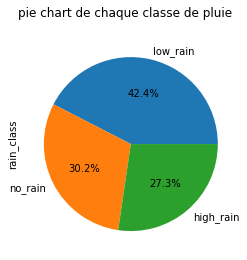

In [251]:
meteo['rain_class'].value_counts().plot.pie(subplots=True, title="pie chart de chaque classe de pluie", autopct='%1.1f%%')

(<Figure size 432x288 with 3 Axes>,
 {('April', 'low_rain'): (0.0, 0.0, 0.07301884712884381, 0.48731725602898907),
  ('April', 'high_rain'): (0.0,
   0.4906285143071348,
   0.07301884712884381,
   0.14994377108584275),
  ('April', 'no_rain'): (0.0,
   0.6438835436711232,
   0.07301884712884381,
   0.3561164563288767),
  ('August', 'low_rain'): (0.07775818362173481,
   0.0,
   0.07577427532238509,
   0.5237808549066826),
  ('August', 'high_rain'): (0.07775818362173481,
   0.5270921131848283,
   0.07577427532238509,
   0.1444912703190849),
  ('August', 'no_rain'): (0.07775818362173481,
   0.6748946417820589,
   0.07577427532238509,
   0.32510535821794095),
  ('December', 'low_rain'): (0.1582717954370109,
   0.0,
   0.07577427532238509,
   0.505719446116797),
  ('December', 'high_rain'): (0.1582717954370109,
   0.5090307043949427,
   0.07577427532238509,
   0.34316676700782656),
  ('December', 'no_rain'): (0.1582717954370109,
   0.855508729680915,
   0.07577427532238509,
   0.144491270319

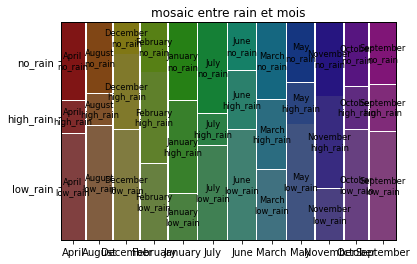

In [252]:
mosaic(meteo, ['date', 'rain_class'],statistic=False, title="mosaic entre rain et mois")

<FONT COLOR="blue"> Parmi les classes de pr√©cipitations de l'√©chantillon, 42.4% correspondent √† des faibles pr√©cipitations, 30,2% correspondent √† des pr√©cipitations nulles et 27,3% √† des pr√©cipitations importantes. 

Ainsi, on peut voir que la majorit√© des observations de M√©t√©o france correspondent √† des jours sans pr√©c√©pitation ou avec tr√®s peu de pr√©cipitations. Dans moins de 30% des jours, il y a de tr√®s fortes pr√©cipitations. 

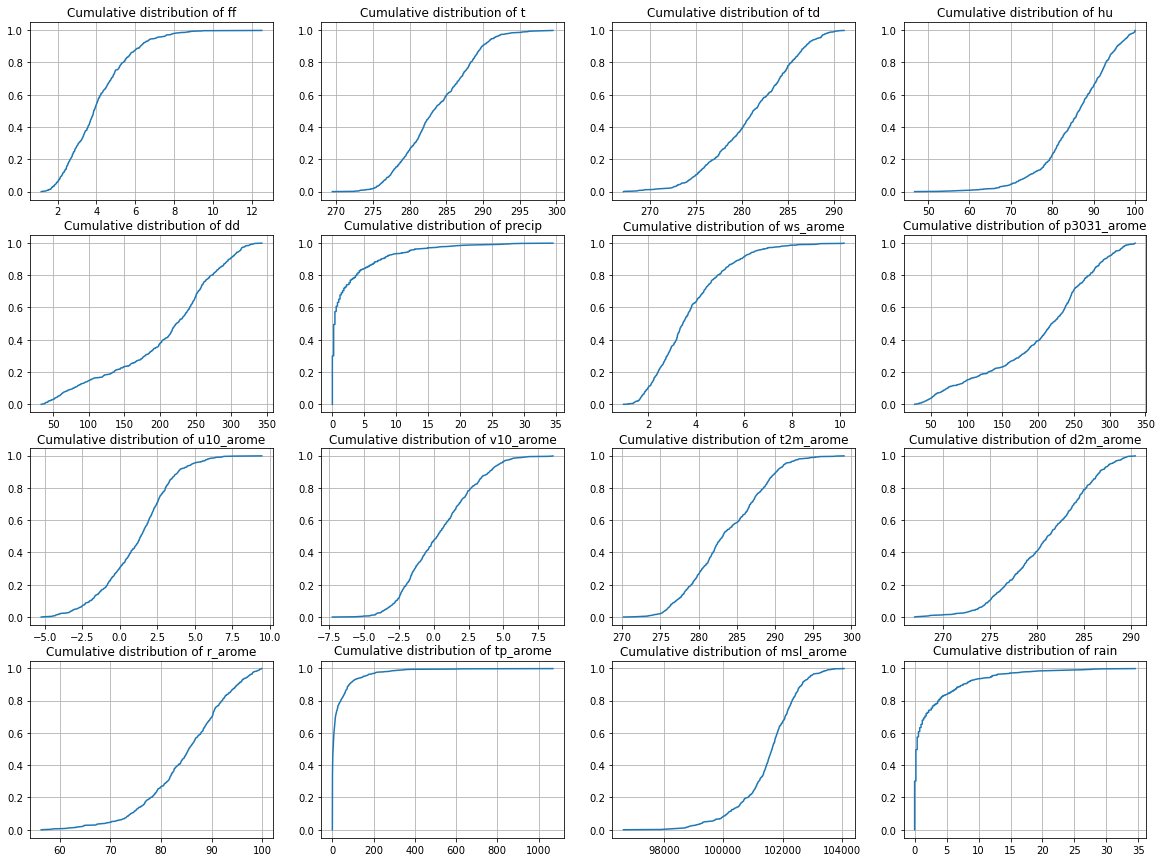

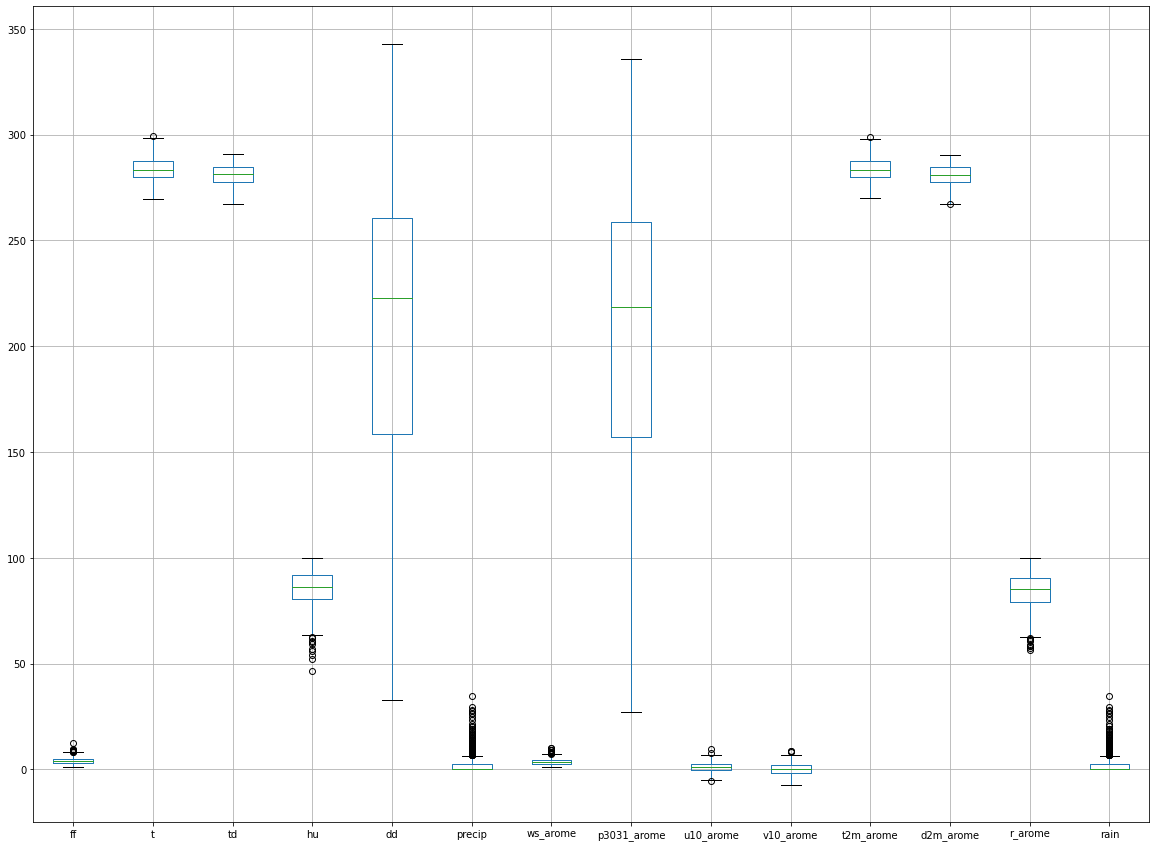

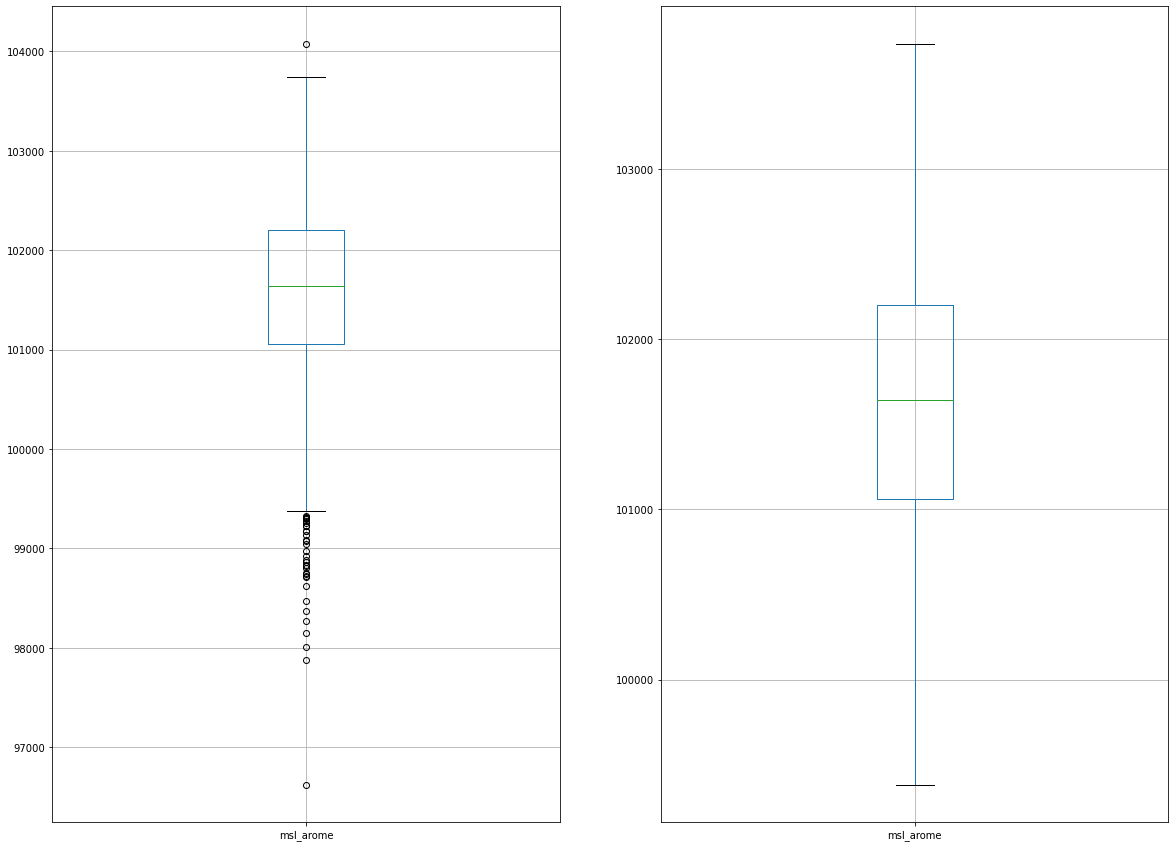

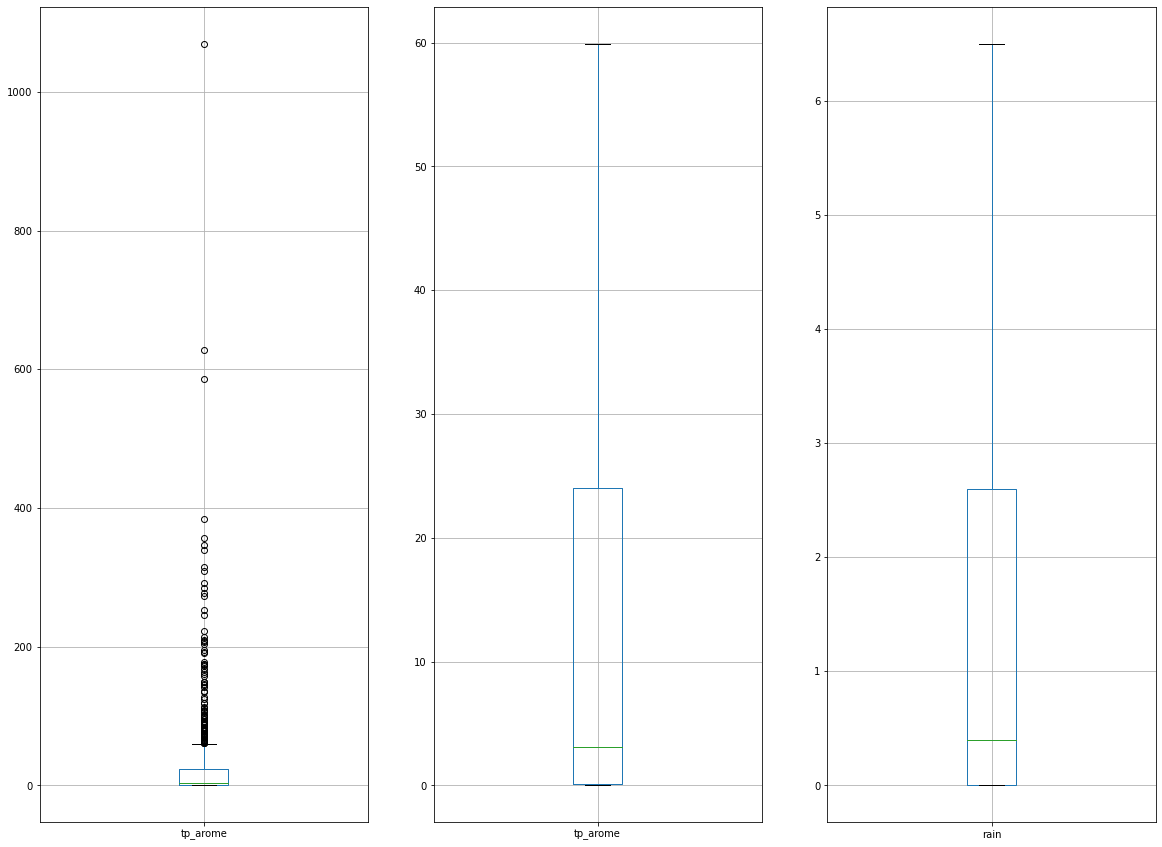

In [253]:
#boxplot des variables quantitatives et distribution 
i=1
fig = plt.figure(figsize=(20, 15))
for x in ["ff", "t", "td", "hu", "dd","precip", "ws_arome", "p3031_arome", "u10_arome", "v10_arome", "t2m_arome", "d2m_arome", "r_arome", "tp_arome","msl_arome","rain"]:
    plt.subplot(4,4, i)
    i+=1
    X2 = np.sort(meteo[x])
    N=len(X2)
    F2 = np.array(range(N))/float(N)
    plt.plot(X2, F2)
    plt.grid()
    plt.title('Cumulative distribution of '+str(x))
    
fig2 = plt.figure(figsize=(20, 15))
boxplot = meteo.boxplot(column=["ff", "t", "td", "hu", "dd","precip", "ws_arome", "p3031_arome", "u10_arome", "v10_arome", "t2m_arome", "d2m_arome", "r_arome","rain"])
fig3 = plt.figure(figsize=(20, 15))
plt.subplot(1,2,1)
boxplot2 = meteo.boxplot(column=["msl_arome"])
plt.subplot(1,2,2)
boxplot2 = meteo.boxplot(column=["msl_arome"], showfliers=False)

fig3 = plt.figure(figsize=(20, 15))
plt.subplot(1,3,1)
boxplot2 = meteo.boxplot(column=["tp_arome"])
plt.subplot(1,3,2)
boxplot2 = meteo.boxplot(column=["tp_arome"], showfliers=False)
plt.subplot(1,3,3)
boxplot2 = meteo.boxplot(column=["rain"], showfliers=False)



<FONT COLOR="blue"> Tout d'abord on voit que si on affiche toutes les variables sur un m√™me boxplot il est illisible car les ordres de grandeur sont tr√®s diff√©rents, ainsi que les unit√©s. 
On constate que les variables tp arome et msl_arome ont beaucoup d'outliers. Il s'agit de variables qui sont pr√©dites par l'algorithme de M√©t√©o France. On voit en regardant tp arome qu'en enlevant les outliers, la m√©diane est 10 fois sup√©rieure que pour rain la vraie quantit√© de pluie. Les pr√©visions ont donc tendance √† surestimer les pr√©cipitations. De plus, on voit que ces deux variables ont une fonction de r√©partition similaire en termes de tendances, seules les valeurs sont diff√©rentes. 

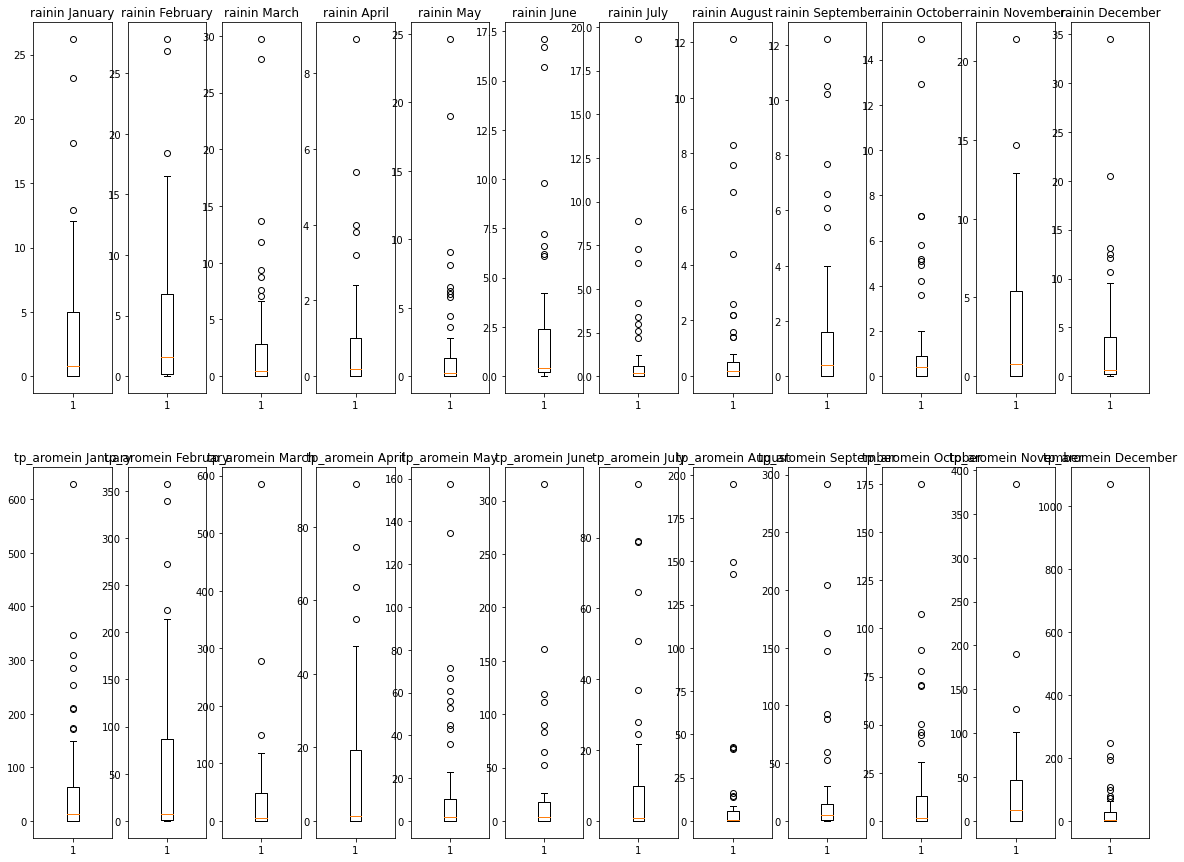

In [254]:
#biplot rain en fonction du mois, et tp_arome en fonction du mois
j=1
fig = plt.figure(figsize=(20, 15))
v=-1
for h in ["rain", "tp_arome"]:
    v+=1
    j=1
    for i in ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]:
        plt.subplot(2,12,j+v*12)
        reqd_Index = np.where(meteo["date"] ==i)
        a=list(meteo[h])
        b=np.zeros((len(a),1))
        b[:,0]=a
        j+=1
        plt.title(str(h) +"in " + str(i))
        plt.boxplot(b[reqd_Index])

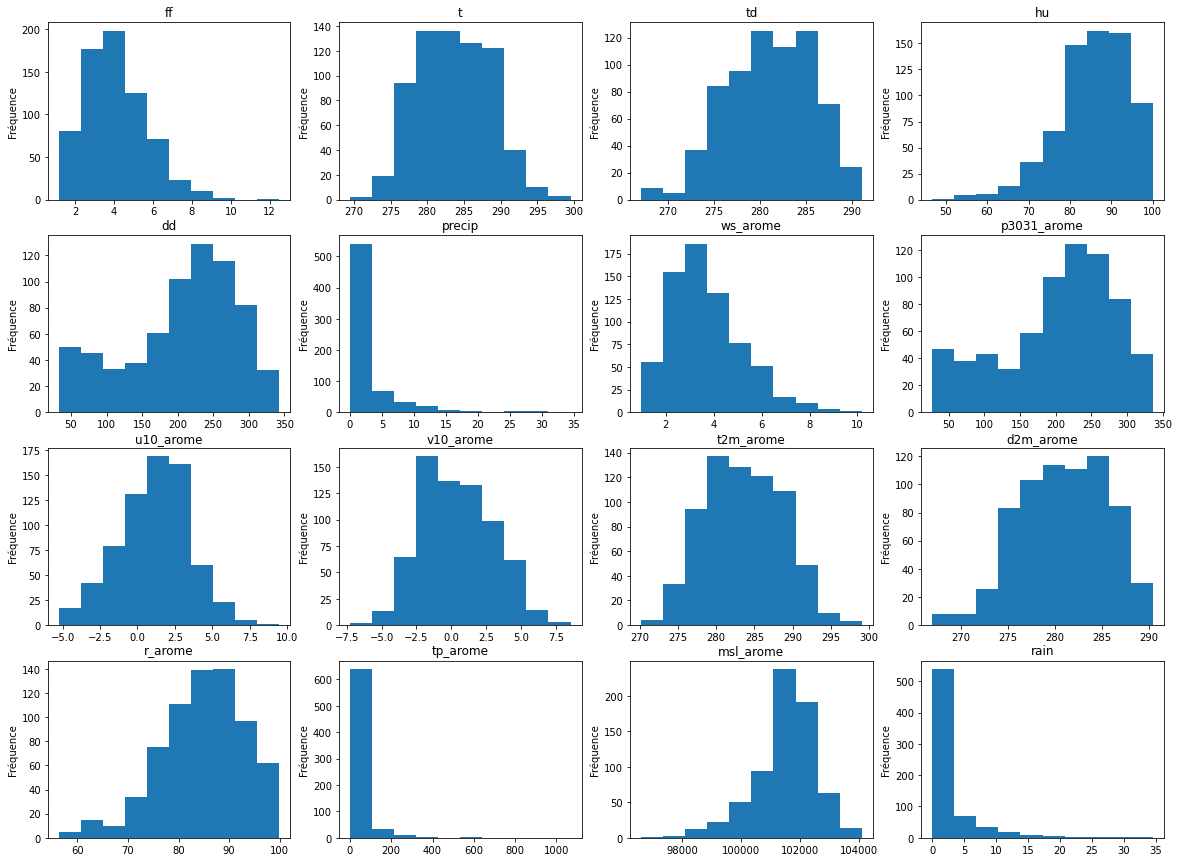

In [255]:
fig = plt.figure(figsize=(20, 15))
p = meteo.columns.size-1
for i in range(1,p):
    plt.subplot(4, 4, i)
    plt.hist(meteo[meteo.columns[i]])
    plt.title(meteo.columns[i])
    plt.ylabel('Fr√©quence')
plt.show()
plt.close()

**Exercice** Traitement des variables : transformations pour une meilleure utilisation des mod√®les lin√©aires. 

In [256]:
app_sqrt = [2,3,5,8,12,13] #liste des variables sur lesquelles on applique sqrt
app_log = [1,7,15] #liste des variables sur lesquelles on applique log
app_tier = [6,11,14,16]
#pas de modif : 9,10
#√† refaire : (2),6,14,16
old_names = meteo.columns #stocker les noms pas modifi√©s
new_names = meteo.columns+"_mod" #nouveaux noms des colonnes modifi√©es

for i in app_sqrt :
    meteo[new_names[i]]=meteo[old_names[i]].map(lambda x: sqrt(x))
    
for i in app_log :
    meteo[new_names[i]]=meteo[old_names[i]].map(lambda x: log(x))

for i in app_tier :
    meteo[new_names[i]]=meteo[old_names[i]].map(lambda x: x**(1/3))
    
for i in app_sqrt+app_log+app_tier:
    del meteo[old_names[i]]
    
meteo.columns

Index(['date', 'hu', 'u10_arome', 'v10_arome', 'rain_class', 't_mod', 'td_mod',
       'dd_mod', 'p3031_arome_mod', 'd2m_arome_mod', 'r_arome_mod', 'ff_mod',
       'ws_arome_mod', 'msl_arome_mod', 'precip_mod', 't2m_arome_mod',
       'tp_arome_mod', 'rain_mod'],
      dtype='object')

**Exercice** V√©rifier l'opportunit√© de ces transformations (histogrammes des nouvelles variables).

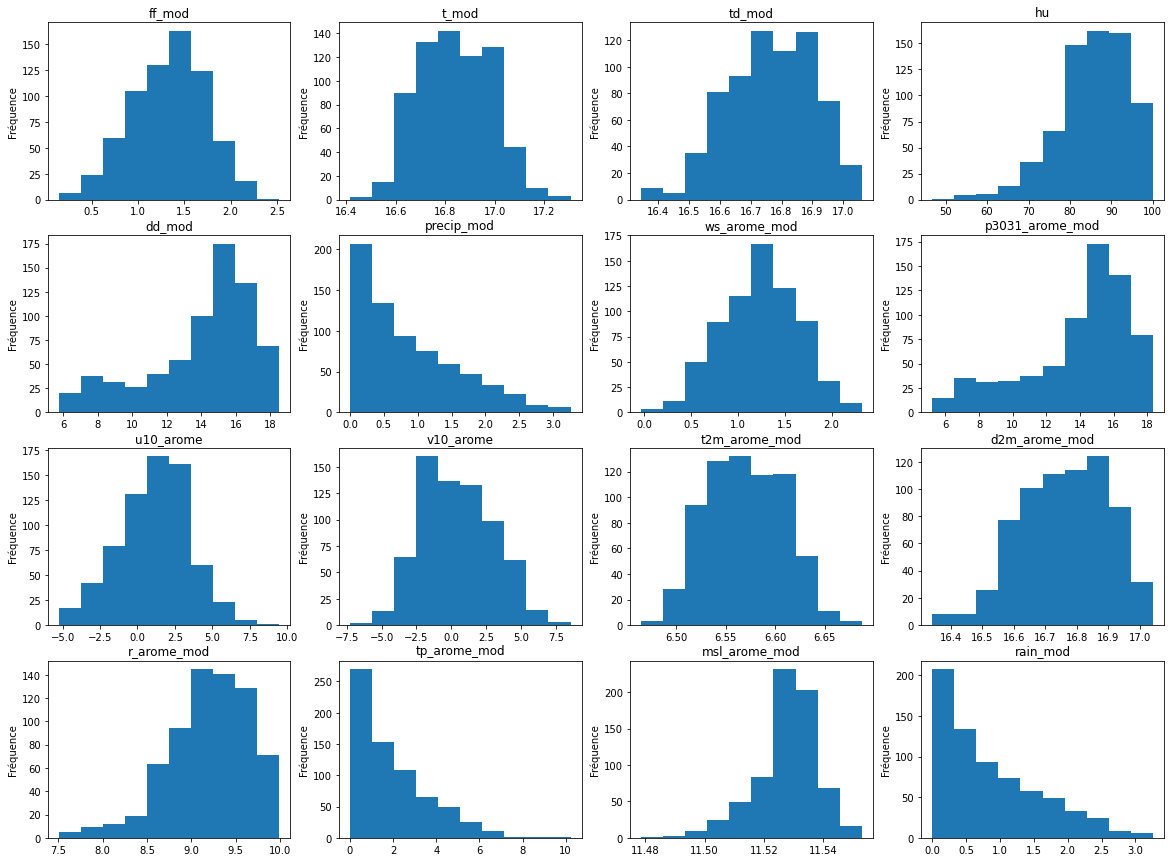

In [257]:
#remettre les variables dans l'ordre pour comparer les affichages facilement
ordre = ["date","ff_mod","t_mod","td_mod","hu","dd_mod","precip_mod","ws_arome_mod","p3031_arome_mod",
        "u10_arome","v10_arome","t2m_arome_mod","d2m_arome_mod","r_arome_mod",
        "tp_arome_mod","msl_arome_mod","rain_mod", "rain_class"]
meteo = meteo[ordre] 

fig = plt.figure(figsize=(20, 15))
p = meteo.columns.size-1
for i in range(1,p):
    plt.subplot(4, 4, i)
    plt.hist(meteo[meteo.columns[i]])
    plt.title(meteo.columns[i])
    plt.ylabel('Fr√©quence')
plt.show()
plt.close()

### Analyse unidimensionelle des variables d'entr√©e :

Au vu des graphiques pr√©c√©dents, on √©tabli une analyse unidimensionnelle pour chacune des variables. 

**Les variables relatives √† la vitesse du vent :**

- **ff** : vitesse du vent le jour J (en $m.s^{-1}$) : la vitesse du vent ressemble √† une distribution gaussienne, environ 175 individus ont une valeur de ff autour de la moyenne qui est de $4 m.s^{-1}$. L‚Äô√©tendue et l‚Äô√©cart interquartiles sont assez faible. On observe quelques outliers dans les valeurs hautes. La force du vent est donc en g√©n√©rale assez constante et basse sauf pour quelques dates o√π elle est plus importante. 

- **ws_arome** : vitesse du vent pr√©dite pour le lendemain (en $m.s^{-1}$) : Globalement on peut faire les m√™mes observations que sur *ff*, √† la diff√©rence que ws_arome prend des valeurs un peu plus basses en terme de moyenne mais aussi de valeurs extr√™mes (son maximum est par exemple de $10 m.s^{-1}$ contre $12 m.s^{-1}$ pour *ff*). On peut se poser la question de si le mod√®le AROME a tendence √† sous-estimer la force du vent mais dans l'ensemble la pr√©diction semble correcte. 

**Les variables relatives aux pr√©cipitations :**
- **precip** : quantit√© totale des pr√©cipitations le jour J ($kg.m^{‚àí2}$) : En moyenne les pr√©cipitations sont tr√®s faibles, la m√©diane des observations est √† $0.4 kg.m^{‚àí2}$. La distribution a une forme exponentielle. Elle est fortement impact√©e par des valeurs extr√™mes, il y a un nombre important d'outliers et le maximum de pr√©cipitations est de  $34.5 kg.m^{‚àí2}$

- **tp_arome**: quantit√© totale de pr√©cipitations pr√©dite pour le lendemain($kg.m^{‚àí2}$) : En comparaison avec *precip*, l'√©tendue et l'√©cart interquartile sont plus ress√©r√©s. Il y a √©galement beacoup d'outliers et on observe des valeurs extr√™mes (maximum √† $1069 kg.m^{‚àí2}$ qui semblent aberrantes. Le mod√®le AROME semble avoir du mal √† fournir des pr√©dictions correctes en cas de fortes pr√©cipitations. 

**Les variables relatives √† la temp√©rature et au point de ros√©e :**
- **t** et **t2m_arome** :temp√©rature le jour J et pr√©dite pour le jour suivant (en Kelvin K): Ces deux variables ont une distribution tr√®s similaire, qui ressemble √† une gaussienne, sans valeurs extr√™mes avec une moyenne de 283 K. Dans l'ensemble la donn√©e de temp√©rature ne varie donc pas beaucoup. 

- **td** et **d2m_arome** : point de ros√©e le jour J et pr√©dite pour le jour suivant (en K) : M√™mes observations que pour *t* et *t2m_arome*

**Les variables relatives √† la direction du vent :**
- **dd** et **p3031_arome**: direction du vent le jour J et pr√©dite pour le jour suivant(en degr√©s) : Ces deux variables ont une distribution tr√®s similaire qui ressemble √† une gaussienne avec une moyenne (218 degr√©s) et une m√©diane (203 degr√©s) d√©cal√©es vers les valeurs hautes. L'√©tendue est tr√®s importante et il n'y a pas d'outlier. La direction du vent change beaucoup d'un jour sur l'autre mais le mod√®le AROME en fournit quand m√™me une bonne pr√©diction.


- **u10_arome** et **vu10_arome**: composantes U du vent (d'Ouest en Est) et V (du Sud au Nord), prise √† 10m de hauteur et pr√©dites pour le jour suivant (en $m.s^{-1}$): Sur ces deux variables la distribution ressemble √† une gaussienne, l'√©tendue est faible. Les composantes U et V restent relativement constantes. 

**Les variables relatives √† l'humidit√© :**
- **hu** et **r_arome** : humidit√© le jour J et pr√©dite pour le jour suivant (en %) : La distribution a une forme de gaussienne avec la moyenne (de 85%) d√©cal√©e vers les grandes valeurs et une queue assez importante qui s'√©tend sur les faibles valeurs (minimum √† 50%). L'√©tendue est importante, on a donc une forte variation de l'humidit√© au cours de l'ann√©e. La pr√©diction fournit par AROME semble tr√®s correcte. 

**La variable relative √† la pression atmosph√©rique :**

- **msl_arome**: pression atmosph√©rique (en Pa) : La distribution a une forme de gaussienne tr√®s bien centr√©es. Il y a beaucoup d'outlier sur les valeurs basses, ces valeurs sont aberrantes au vu de la r√©gularit√© du reste de la distribution.

### Analyse unidimensionelle des variables de sortie :
- **rain** : quantit√© totale de pr√©cipitation le jour suivant $kg.m^{‚àí2}$ : La distribution ressemble a une forme d'exponentielle d√©croissante. La m√©diane (de $0.4 kg.m^{‚àí2}$) et la moyenne (de $2.3 kg.m^{‚àí2}$ sont tr√®s basses et l'√©tendue est tr√®s faible. Mais on observe un tr√®s grand nombre d'outlier. On peut remettre en question l'efficacit√© du mod√®le AROME pour pr√©dire la variable rain_mod lorsque la quantit√© de plus est importante. 

- **rain_class**: cat√©gorie de pr√©cipitations : no_rain (si rain=0), low_rain (si 0<rain<2), high_rain (si rain>2). Chaque modalit√© repr√©sente environ un tier des observations. Au cours de l'ann√©e on a donc √† peu pr√®s √† parts √©gales des pluies fortes, moyennes et nulles. 

## 3. Exploration multidimensionnelle

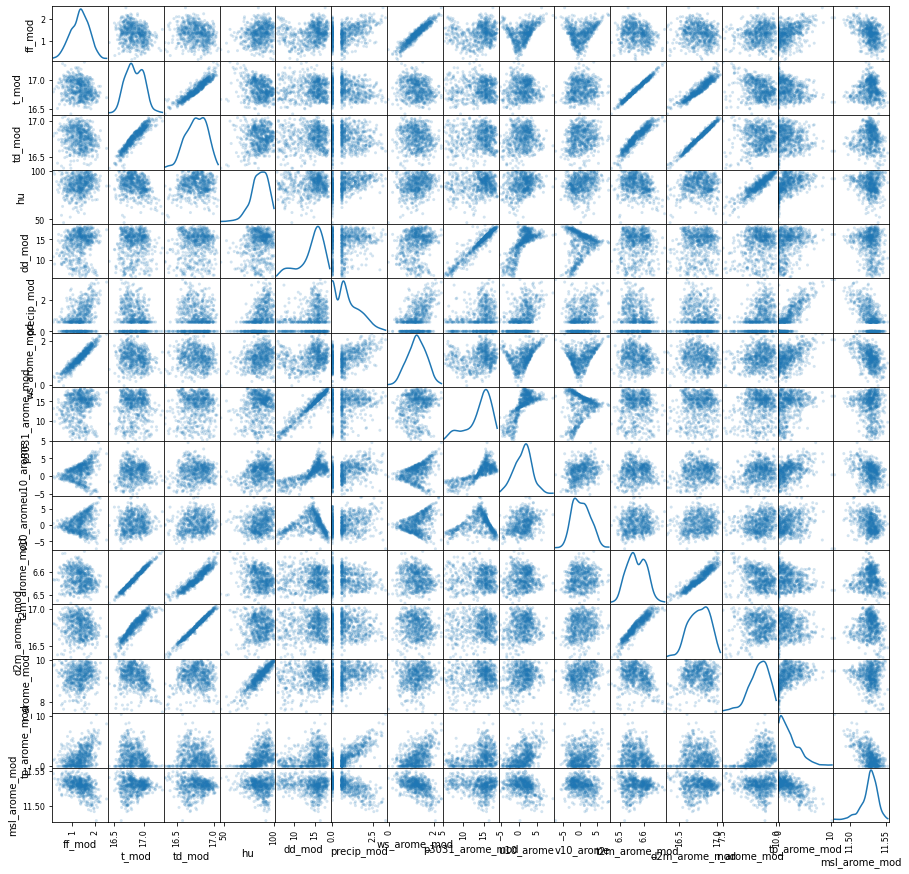

In [258]:
# scatter plot matrix des variables quantitatives
#from pandas.plotting import scatter_matrix
scatter_matrix(meteo[ordre[1:p-1]], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

**Q** Commenter les relations entre les variables prises 2 √† 2.

<FONT COLOR="Blue">
La temp√©rature pr√©dite et la temp√©rature actuelle sont tr√®s corr√©l√©es positivement, ainsi que la temp√©rature et le point de ros√©e. les variables tr√®s corr√©l√©es sont ainsi les temp√©ratures entre elles, le vent actuel et pr√©dit, les points de ros√©e, le point de ros√©e et la temp√©rature. 
Cela est coh√©rent car la temp√©rature du jour suivant d√©pend g√©n√©ralement beaucoup de la temp√©rature du jour pr√©sent.
</font>    

/home/julie/anaconda3/lib/python3.8/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


<AxesSubplot:>

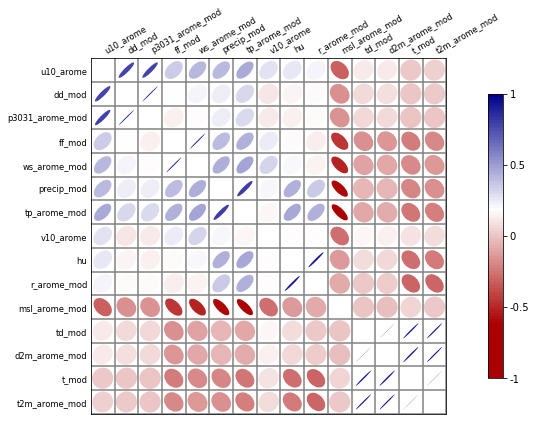

In [259]:
#import pyensae
#from pyensae.graphhelper import Corrplot
c = Corrplot(meteo[ordre[1:p-1]])
c.plot(figsize=(12,6))
## je ne sais pas pourquoi les variables ne sont pas affich√©es dans l'ordre que j'ai donn√©

<Figure size 1152x1152 with 0 Axes>

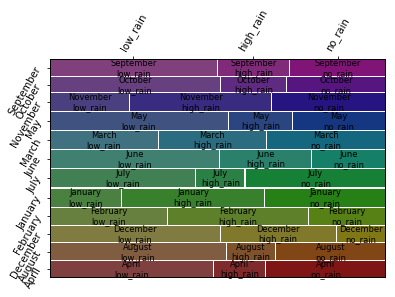

In [260]:
from statsmodels.graphics.mosaicplot import mosaic
crosstable=pd.crosstab(meteo['date'],meteo['rain_class'])

plt.figure(figsize=(16,16))

Fig, _=mosaic(meteo,['date','rain_class'], ax=None, horizontal=False, label_rotation=60)


## 4. Analyse en Composantes Principales

In [261]:
## Avant de r√©aliser on supprime la variable √† expliquer : rain_mod
ordre1 = np.delete(ordre,ordre.index("rain_mod"))
X=scale(meteo[ordre1[1:-1]])
#r√©duit et centre les donn√©es 
print(np.shape(X))

#Pourquoi faire une ACP centr√©e r√©duite ? 
#On choisit de faire une ACP r√©duite, car ici les donn√©es n'ont pas la m√™me unit√© et sont d'ordre de grandeur tr√®s diff√©rent

(688, 15)


Tous les r√©sultats num√©triques classiques sont fournis par l'[impl√©mentation](http://scikit-learn.org/stable/modules/decomposition.html) de scikit-learn mais des  efforts sont √† produire pour construire les graphiques usuels g√©n√©ralement automatiquement produits par des librairies d√©di√©es comme [FactoMineR](http://factominer.free.fr/) de R.

Les commandes suivantes permettent de r√©aliser une analyse en composantes principales sur les seules variables quantitatives. Par ailleurs la variable √† mod√©liser n'est pas utilis√©e.

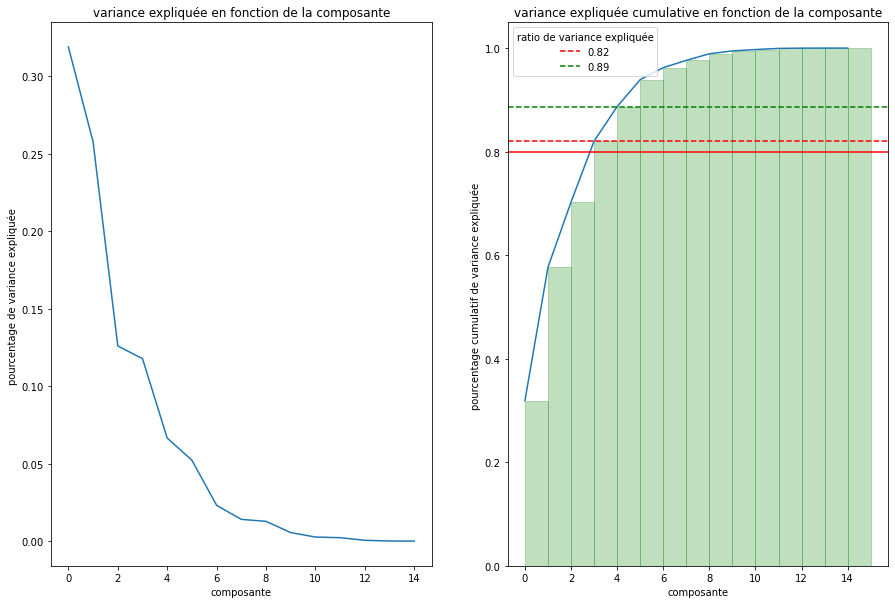

valeurs propres :  [57.37258951 51.57085892 36.05447895 34.86183022 26.20029701 23.21411463
 15.44855511 12.03686463 11.4741051   7.53723064  5.20577485  4.77235054
  2.3430721   0.81963416  0.40377733]


In [262]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)


## D√©croissance de la variance expliqu√©e
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.title("variance expliqu√©e en fonction de la composante")
plt.xlabel("composante")
plt.ylabel("pourcentage de variance expliqu√©e ")

plt.subplot(1,2,2)
var_cum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_cum)

x=np.arange(0,len(var_cum))+0.5*np.ones(len(var_cum))
plt.bar(x, var_cum, 1, color='g', edgecolor="g", alpha=0.25)

plt.axhline(y=0.8, c='r')
plt.axhline(y=var_cum[3], color='r', linestyle='--',label=round(var_cum[3],2))
plt.axhline(y=var_cum[4], color='g', linestyle='--',label=round(var_cum[4],2))

plt.title("variance expliqu√©e cumulative en fonction de la composante")
plt.xlabel("composante")
plt.ylabel("pourcentage cumulatif de variance expliqu√©e ")
plt.legend(title="ratio de variance expliqu√©e")
plt.show()
plt.close()

#vecteur des valeurs propres 
print("valeurs propres : ",pca.singular_values_)
#print((pca.singular_values_[:-1]-(+pca.singular_values_[1:]))/pca.singular_values_[:-1])
#id√©e ; on peut aussi regarder la d√©croissances des vps. 

<font color="blue"> **Analyse :** 
L'analyse des graphiques sugg√®re de garder les 4 premi√®res composantes de l'ACP pour r√©duire la dimension sans perdre une quantit√© trop imporante d'information. 
En effet, sur le graphique des pourcentages cumul√©es d'intertie, on voit qu'avec 4 composantes on explique 83% de l'inertie. 
On peut aussi observer sur les boxplots que la variance est beaucoup plus importante sur les 4 premiers boxplots que sur les suivants. 

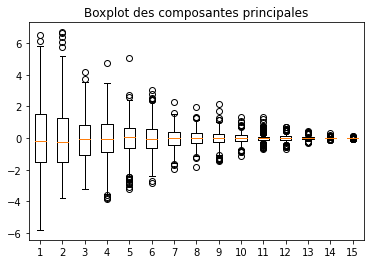

liste des outliers :  [256, 649, 394, 141, 528, 657, 661, 279, 281, 550, 298, 48, 569, 187, 450, 327, 332, 77, 588, 592, 337, 594, 211, 597, 96, 224, 355, 240, 498]


In [263]:
## distribution des composantes principales
plt.figure()
plt.boxplot(C[:,:])
plt.title("Boxplot des composantes principales")
plt.show()
plt.close()


nb_compo_conservees=5

############TROUVER LES VALEURS ABERRANTES (renvoie les indices de la colonne de C) ######
def outlier(n):#n est le num√©ro de la colonne de C 
    Q1 = np.percentile(C[:,n], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(C[:,n], 75,
                   interpolation = 'midpoint')
    
    upper = C[:,n] >= (Q3+1.5*(Q3-Q1))
    lower = C[:,n] <= (Q1-1.5*(Q3-Q1))
    #print("indices des outliers au dessus :", np.where(upper), "indices des outliers en dessous", np.where(lower))
    return np.where(lower), np.where(upper)

#construction de la liste des outliers 
#lower, upper=outlier(0)
#print(lower)
#print(upper)
x=[]
for n in range (0,nb_compo_conservees): 
    lower, upper=outlier(n)
    x=x+list(lower[0])+list(upper[0])

y=list(set(x)) #passer au set permet de supprimer les doublons

C_sans_outlier=np.delete(C, y, 0) #supprime les outliers
X_sans_outlier=np.delete(X, y, 0)
print("liste des outliers : ",y)

**Q** Commenter ces r√©sultats: quel choix de la dimension? 
On observe ici les valeurs prises par les individus quand ils sont projet√©s sur les diff√©rentes composantes, on voit que 
**Q** Pr√©sence de valeurs atypiques.

<FONT COLOR="blue"> **Pourcentage cumul√© de variance expliqu√©e** : Plus l'inertie d'une composante principale est grande (valeur propre importante), mieux elle conserve des donn√©es, c'est √† dire que l'information est bien conserv√©e par projection sur l'axe. Pour d√©terminer le nombre de composantes principales √† garder, on s‚Äôint√©resse donc √† l‚Äôinertie de chacune de ces composants. Pour avoir 80% de l‚Äôinertie globale, il faut garder au moins les quatre premi√®res composantes : elles cumulent √† elles seules 82% de l‚Äôinertie globale

**Boxplot** : Le boxplot nous permet d'observer la distribution des projections. Avec le boxplot on voit que l'ensemble des projections sont bien sur les dimensions 1, 2,3,4 : on remarque que ces premi√®res composantes contiennent presque toute la variance. Cela nous fait alors consid√©rer les 4 premi√®res composantes.
    
**Eboulis** : Sur le graphique pr√©sentant la d√©croissance des valeurs propres on remarque un coude au niveau de la composante. On doit garder toutes les composantes qui pr√©c√®dent ce coude. On garde ici 4 composantes
    
<FONT COLOR="blue"> Les composantes sont relativement sym√©triques, mais on constate que pour les composantes il y a entre 1 et 8 outliers. Ce sont des valeurs atypiques qui peuvent biaiser les r√©sultats fournis par l'ACP, car la matrice de covariance est sensible aux outliers.La variance de ces composantes peut etre surestim√©e. Il faudra donc tester sans les valeurs des outliers pour v√©rifier la validit√© de notre ACP. 

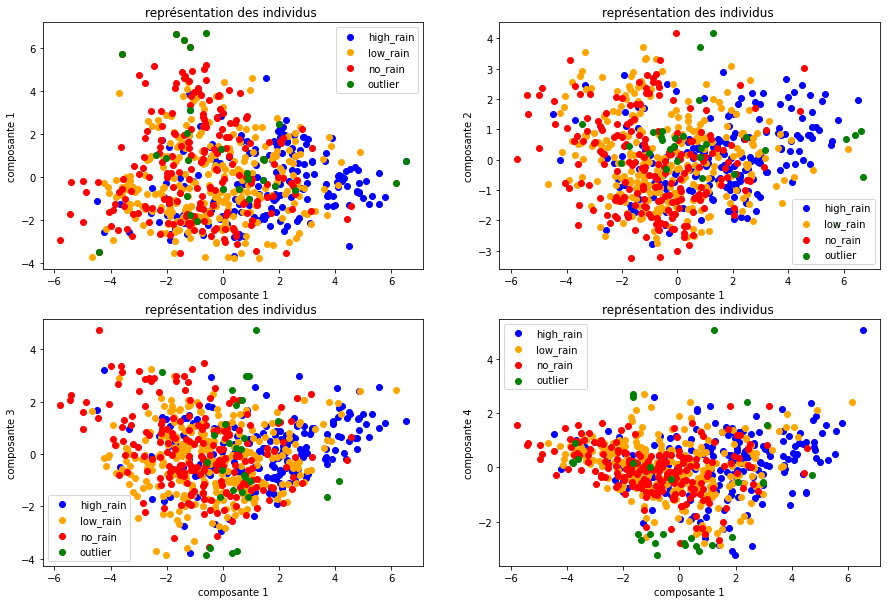

In [264]:
## Repr√©sentation des individus
highrain=np.where(meteo['rain_class']=="high_rain")
lowrain=np.where(meteo['rain_class']=="low_rain")
norain=np.where(meteo['rain_class']=="no_rain")

plt.figure(figsize=(15, 10))

pos=0
for i in range(0,4):
    pos+=1
    plt.subplot(2,2,pos)
    plt.scatter(C[highrain,0], C[highrain,i+1], c="b", label="high_rain")
    plt.scatter(C[lowrain,0], C[lowrain,i+1], c="orange", label="low_rain")
    plt.scatter(C[norain,0], C[norain,i+1], c="r", label="no_rain")
    plt.scatter(C[y,i], C[y,i+1], c="g", label="outlier")
    plt.title("repr√©sentation des individus ")
    plt.xlabel("composante 1")
    plt.ylabel("composante {}".format(i+1))
    plt.legend()

**analyse du graphe des individus** : 
- On a du mal √† distinguer une s√©paration entre les modalit√©s *high_rain*, *low_rain* et *no rain*. Il semblerait que les individus les plus √† droite sur la dimension 1 portent la modalit√© *high_rain*, mais les deux autres modalit√©s sont assez m√©lang√©es comme on eput le voir sur le dernier graphe o√π leurs ellipses se superposent. 
- Remarque sur les outliers : Les outliers 354,348 et 636 ont de tr√®s faibles valeurs de pr√©cipitations (precip_mod et tp_arome_mod), leurs valeurs sur ces variables correspondent au minimum. Cela s'observe aussi sur le premier graphique pour lequel les points les plus en bas autour de l'axe de la dimension 2 portent tous la mention "no rain". 

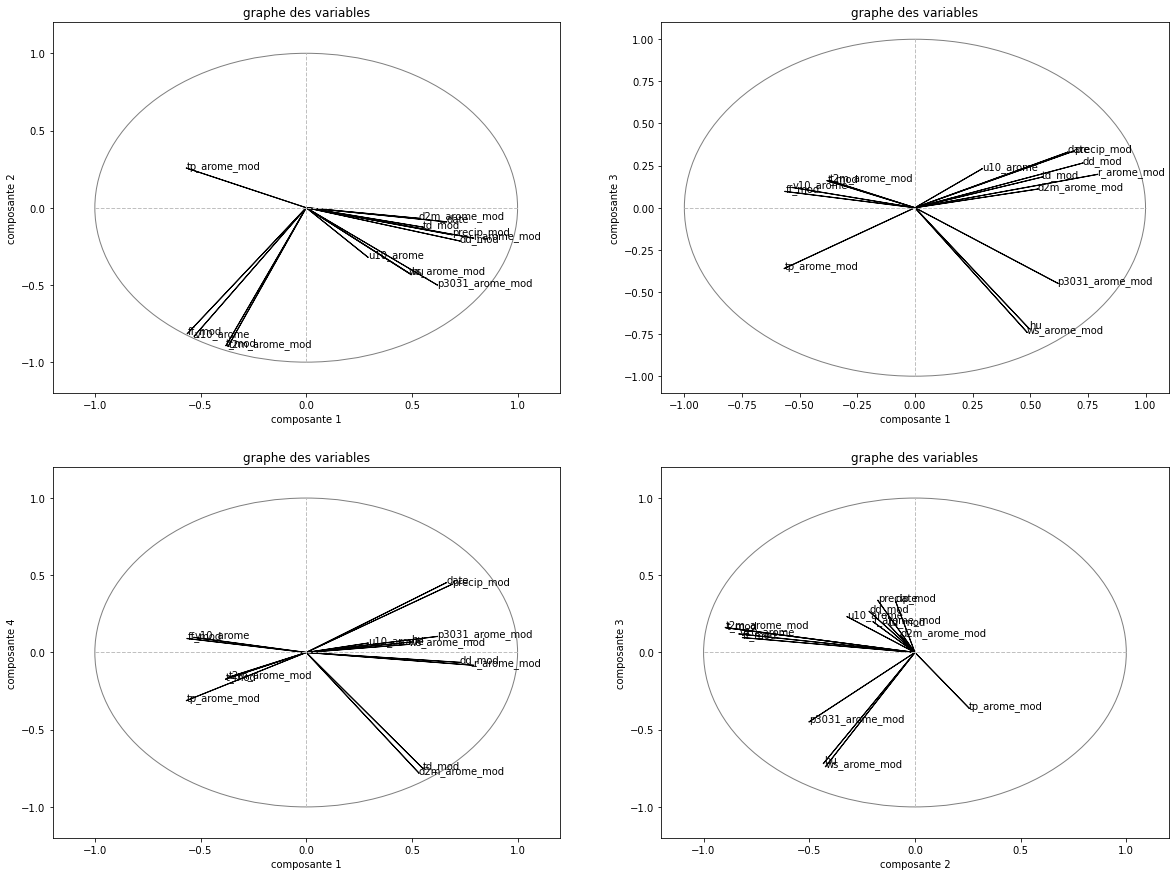

In [265]:
## coordonn√©es et repr√©sentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
coord3=pca.components_[2]*np.sqrt(pca.explained_variance_[2])
coord4=pca.components_[3]*np.sqrt(pca.explained_variance_[3])

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(2, 2, 1)
for i, j, nom in zip(coord1,coord2, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
e=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
plt.xlabel("composante 1")
plt.ylabel("composante 2")
plt.title("graphe des variables")
ax.add_patch(e)

ax2 = fig.add_subplot(2, 2, 2)
for i, j, nom in zip(coord1,coord3, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
plt.xlabel("composante 1")
plt.ylabel("composante 3")
plt.title("graphe des variables")
ax2.add_patch(c)


ax3= fig.add_subplot(2, 2,3)
for i, j, nom in zip(coord1,coord4, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
    plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
d=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
ax3.add_patch(d)
plt.xlabel("composante 1")
plt.ylabel("composante 4")
plt.title("graphe des variables")

ax4= fig.add_subplot(2, 2,4)
for i, j, nom in zip(coord2,coord3, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
    plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
d=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
ax4.add_patch(d)
plt.xlabel("composante 2")
plt.ylabel("composante 3")
plt.title("graphe des variables")

plt.axis((-1.2,1.2,-1.2,1.2))
plt.show()

**Analyse :** 
Le graphe PCA des individus permet d'observer les m√™mes corr√©lations entre les variables que sur le corrplot. 

Variables bien projet√©es sur la **dimension 1** : 
- Les variables relatives √† la vitesse du vent (ff_mod, ws_arome_mod) 
- les variables relatives aux pr√©cipitations (precip_mod et tp_arome)

Variables bien projet√©es sur la **dimension 2** :
- Les variables relatives √† la temp√©rature et au point de ros√©e (t_mod, td_mod, t2m_arome_mod et d2m_arome_mod)

Variables bien projet√©es sur la **dimension 3** :
- Les variables relatives √† la direction du vent (dd_mod, p3031_arome_mod, u10_arome)

Variables bien projet√©es sur la **dimension 4** :
- Les variables relatives √† l'humidit√© (hu et r_arome)

**Q** Commenter la structure de corr√©lation des variables.

<FONT COLOR="Blue"> Quand on regarde la composante 1 contre les autres composantes on arrive globalement sur chacune des repr√©sentations ci-dessus √† distinguer 4 √† 6 groupes de variables corr√©l√©es. Cela sugg√®re qu'on aura besoin de garder 4 √† 6 composantes principales dans l'ACP, c'est-√†-dire qu'on va pouvoir r√©duire la dimension. </font>

**Q** L'objectif est de d√©finir une surface s√©parant les deux classes. Une discriminaiton lin√©aire (hyperplan) semble-t-elle possible?  

<FONT COLOR="Blue"> Comme on peut le voir dans le clustering suivant, il est possible de d√©finir une surface s√©parant des classes lorsque l'on compare la composante 1 qui porte le plus d'information aux autres composantes. </font>

### Clustering (K-Means)

In [266]:
#from sklearn.cluster  import  KMeans
#from  sklearn.metrics  import confusion_matrix
clust=KMeans(n_clusters=4)
clust.fit(X)
classe=clust.labels_


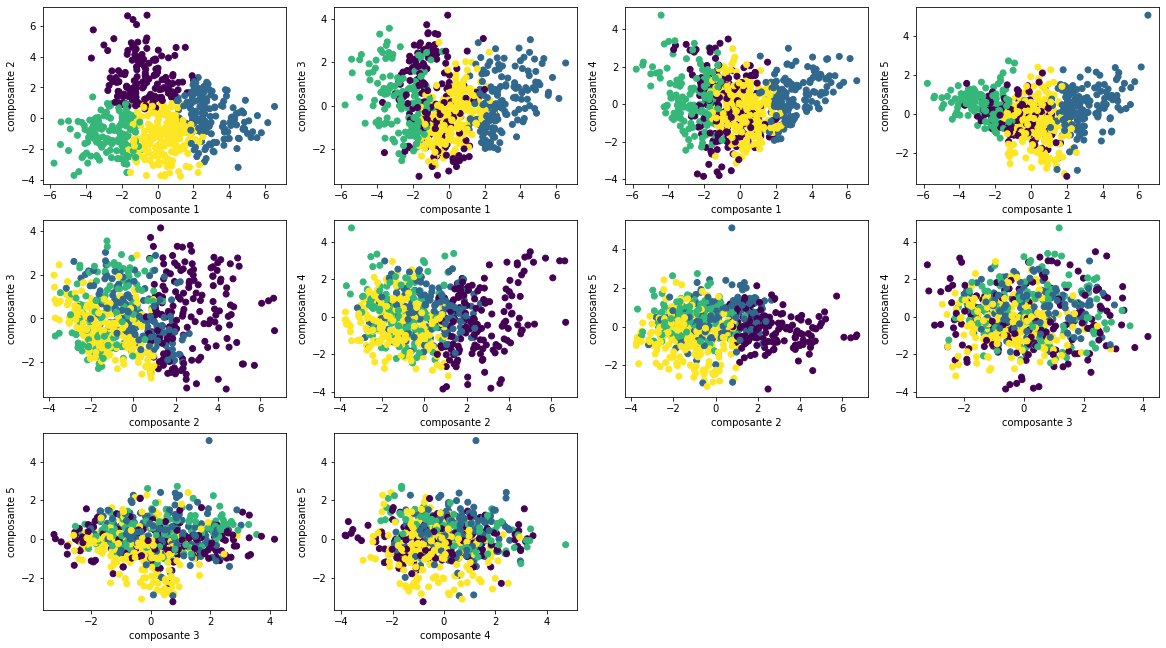

In [267]:
## Rep√©sentation des individus dans les coordonn√©es de l'acp.
pos = 0
fig = plt.figure(figsize=(20, 15))
for i in range(0,nb_compo_conservees):
    for j in range(i+1,nb_compo_conservees):
        pos += 1
        plt.subplot(4, 4, pos)
        plt.scatter(C[:,i], C[:,j], c=classe)
        plt.xlabel("composante {}".format(i+1))
        plt.ylabel("composante {}".format(j+1))
plt.show()


###  LDA ("ACP supervis√©e")

Text(0.5, 1.0, 'LDA rain_class')

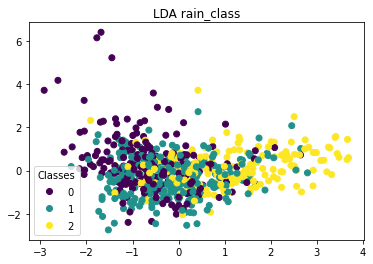

In [268]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_r2 = lda.fit(X, list(meteo["rain_class"])).transform(X)

meteo_rain_num=np.copy(list(meteo['rain_class']))
meteo_rain_num[np.where(meteo['rain_class']=="high_rain")]=2
meteo_rain_num[np.where(meteo['rain_class']=="low_rain")]=1
meteo_rain_num[np.where(meteo['rain_class']=="no_rain")]=0
fig, ax = plt.subplots()

# Because the price is much too small when being provided as size for ``s``,
# we normalize it to some useful point sizes, s=0.3*(price*3)**2
scatter = ax.scatter(X_r2[:,0], X_r2[:,1], c=meteo_rain_num.astype(int))

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

plt.title("LDA rain_class")

In [269]:
print(lda.coef_)
print(lda.classes_)

tmp= pd.DataFrame(lda.coef_.transpose(),columns=lda.classes_)
print(tmp)

[[ 0.18202841 -1.14480277  0.20771721 -0.08476215 -0.05311863  0.44005696
  -0.32433346  0.07219359  0.45777183  0.27876859  2.81483508 -2.173947
   0.81661806 -0.41394658 -0.80896989]
 [ 0.01434861 -3.99108032  2.74681685 -1.14641748  0.186732    0.05710393
  -0.07002423 -0.29436716 -0.01635478 -0.01376431  4.33459404 -2.83481446
   1.21922674  0.06559876  0.33032871]
 [-0.18466892  6.63758835 -4.04385267  1.68600572 -0.21413193 -0.47790891
   0.39145079  0.34799431 -0.39079571 -0.23264095 -8.62928103  5.94455701
  -2.44970385  0.28205346  0.26745364]]
['high_rain' 'low_rain' 'no_rain']
    high_rain  low_rain   no_rain
0    0.182028  0.014349 -0.184669
1   -1.144803 -3.991080  6.637588
2    0.207717  2.746817 -4.043853
3   -0.084762 -1.146417  1.686006
4   -0.053119  0.186732 -0.214132
5    0.440057  0.057104 -0.477909
6   -0.324333 -0.070024  0.391451
7    0.072194 -0.294367  0.347994
8    0.457772 -0.016355 -0.390796
9    0.278769 -0.013764 -0.232641
10   2.814835  4.334594 -8.6292

In [270]:

# variable √† expliquer multinomiale
Yb=meteo["rain_class"]
# variable √† expliquer r√©elle
Yr=meteo["rain_mod"]
meteoDum=pd.get_dummies(meteo[["date"]])
meteoQuant=meteo[["ff_mod","t_mod","td_mod","hu","dd_mod","precip_mod","ws_arome_mod","p3031_arome_mod","u10_arome","v10_arome","t2m_arome_mod","d2m_arome_mod","r_arome_mod","tp_arome_mod","msl_arome_mod"]]
mat=pd.concat([meteoDum,meteoQuant],axis=1)
X_train,X_test,Yb_train,Yb_test=train_test_split(mat,Yb,test_size=0.2,random_state=11)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, Yb_train)

# without cross-valdidation
prediction = clf.predict(X_test)

table=pd.crosstab(prediction, Yb_test, dropna=False)
table

rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          18         9        4
low_rain           14        35       21
no_rain             3        12       22

In [271]:
purity(table)

0.5434782608695652

In [272]:
print(np.diag(table)/np.sum(table,axis=0))

rain_class
high_rain    0.514286
low_rain     0.625000
no_rain      0.468085
dtype: float64


<FONT COLOR="Blue"> On fait une cross tab pour faire l'erreur de g√©n√©ralisation obtenue sur l'√©chantillon test, on voit que cette matrice est presque sym√©trique. On voit que le taux de r√©ussite n'est pas tr√®s bon pour chaque classe 

<FONT COLOR="Blue"> La LDA est une m√©thode qui tient compte de class_rain pour faire l'ACP. La LDA est donc une sorte d'acp SUPERVISEE. Elle suppose deux hypyth√®ses v√©rifi√©es : 
que la structure de variance soit identique pour toutes les classes et qu'elles sont gaussienne.Ici on voit que les nuages ne sont pas forc√©ment sph√©riques, car les variances ne sont pas forc√©ment identiques dans les diff√©rentes activit√©s. On voit qu'elle n'est pas vraiment discriminante, que les classes low rain et no rain sont presque confondues. Seule la classe high rain est l√©g√®rement plus discrimin√©e, mais cela reste encore relatif.

## Mod√©lisations

La recherche  d'une meilleure m√©thode de pr√©vision suit g√©n√©ralement le protocole suivant dont la premi√®re √©tape est d√©ja r√©alis√©e.


1. Etape descriptive pr√©liminaire uni et multidimensionnelle visant √† rep√©rer les incoh√©rences, les variables non significatives ou de distribution exotique, les individus non concern√©s ou atypiques... et √† √©tudier les structures des donn√©es. Ce peut √™tre aussi la longue √©tape de construction de variables, attributs ou *features* sp√©cifiques des donn√©es. 
2. Proc√©der √† un tirage al√©atoire d'un √©chantillon *test* qui ne sera utilis√© que lors de la *derni√®re √©tape* de comparaison des m√©thodes.
3. La partie restante est l'√©chantillon d'*apprentissage* pour l'estimation des param√®tres des mod√®les.
4. Pour chacune des m√©thodes, optimiser la complexit√© des mod√®les en minimisant une estimation "sans biais" de l'erreur de pr√©vision, par exemple par [*validation crois√©e*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf).
    - Variables et interactions √† prendre en compte dans la r√©gression lin√©aire ou logistique;
    - variables et m√©thode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de r√©gression ou de classification;
    - architecture (nombre de neurones, p√©nalisation) du perceptron;
    - algorithme d'agr√©gation, 
    - noyau et p√©nalisation des SVMs.
5.  Comparaison des qualit√©s de pr√©vision sur la base du taux de mal class√©s pour le seul √©chantillon test qui est rest√© √† l'√©cart de tout effort ou "acharnement" pour l'optimisation des mod√®les.

**Remarques**
* En cas d'√©chantillon relativement "petit" il est recommand√© d'it√©rer la proc√©dure de d√©coupage apprentissage / test ([validation crois√©e *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)), afin de r√©duire la variance (moyenne) des estimations des erreurs de pr√©vision.
* *Attention*: ne pas "tricher" en modifiant le mod√®le obtenu lors de l'√©tape pr√©c√©dente afin d'am√©liorer le r√©sultat sur l'√©chantillon test !
* Le crit√®re utilis√© d√©pend du probl√®me : erreur quadratique, taux de mauvais classement, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...
* L'√©tape "choix" de la meilleure m√©thode peut √™tre remplac√©e par une combinaisons de pr√©vision comme c'est souvent le cas dans les soutions "gagnantes" mais lourdes du site [kaggle](https://www.kaggle.com/competitions).

### Extraction des √©chantillons apprentissage et test

Transformation des donn√©es pour l'apprentissage. 

<FONT COLOR="Blue">On transforme la variable qualitatitve **date** en variable quantitative en utilisant des indicatrices. La premi√®re modalit√© **date_January** est automatiquement supprim√©e (ce qui revient √† la mettre dans l'intercept) pour garder un mod√®le r√©gulier. 

In [273]:
meteo.head()

date    ff_mod      t_mod     td_mod         hu     dd_mod  precip_mod  \
1      June  1.372449  17.012018  16.890148  78.783333  15.708278    0.000000   
2     March  1.318974  16.624555  16.535492  81.700000  16.134848    1.062659   
3      July  1.185936  16.996152  16.932907  87.620833  16.094771    0.584804   
4       May  0.556755  16.860864  16.739649  76.587500  14.715355    0.000000   
5  February  1.743750  16.659169  16.568922  81.391667  16.897978    1.169607   

   ws_arome_mod  p3031_arome_mod  u10_arome  v10_arome  t2m_arome_mod  \
1      1.298497        15.630083   3.038503   1.416360       6.613260   
2      1.202515        17.483156   2.463886  -1.898971       6.509325   
3      1.173219        16.001325   2.963872   0.985627       6.616270   
4      0.542862        11.802426  -0.260693  -1.397603       6.578736   
5      1.487047        16.899077   3.940056  -1.457606       6.524575   

   d2m_arome_mod  r_arome_mod  tp_arome_mod  msl_arome_mod  rain_mod  \
1      16.887003     8.890320      1.325394      11.529516  0.584804   
2      16.543053     9.291480      2.201888      11.518746  1.613429   
3      16.925872     9.071992      1.660969      11.527646  0.000000   
4      16.744173     8.682403      0.979674      11.534918  0.000000   
5      16.570777     8.968561      2.404567      11.536800  0.000000   

  rain_class  
1   low_rain  
2  high_rain  
3    no_rain  
4    no_rain  
5    no_rain

In [274]:
# Variables explicatives
meteoDum=pd.get_dummies(meteo[["date"]])
meteoQuant=meteo[["ff_mod","t_mod","td_mod","hu","dd_mod","precip_mod","ws_arome_mod","p3031_arome_mod","u10_arome","v10_arome","t2m_arome_mod","d2m_arome_mod","r_arome_mod","tp_arome_mod","msl_arome_mod"]]
dfC=pd.concat([meteoDum,meteoQuant],axis=1)
dfCsansmodalite=pd.concat([meteo["date"],meteoQuant],axis=1)
dfCsansmodalite.head()
#dfC.head()

date    ff_mod      t_mod     td_mod         hu     dd_mod  precip_mod  \
1      June  1.372449  17.012018  16.890148  78.783333  15.708278    0.000000   
2     March  1.318974  16.624555  16.535492  81.700000  16.134848    1.062659   
3      July  1.185936  16.996152  16.932907  87.620833  16.094771    0.584804   
4       May  0.556755  16.860864  16.739649  76.587500  14.715355    0.000000   
5  February  1.743750  16.659169  16.568922  81.391667  16.897978    1.169607   

   ws_arome_mod  p3031_arome_mod  u10_arome  v10_arome  t2m_arome_mod  \
1      1.298497        15.630083   3.038503   1.416360       6.613260   
2      1.202515        17.483156   2.463886  -1.898971       6.509325   
3      1.173219        16.001325   2.963872   0.985627       6.616270   
4      0.542862        11.802426  -0.260693  -1.397603       6.578736   
5      1.487047        16.899077   3.940056  -1.457606       6.524575   

   d2m_arome_mod  r_arome_mod  tp_arome_mod  msl_arome_mod  
1      16.887003     8.890320      1.325394      11.529516  
2      16.543053     9.291480      2.201888      11.518746  
3      16.925872     9.071992      1.660969      11.527646  
4      16.744173     8.682403      0.979674      11.534918  
5      16.570777     8.968561      2.404567      11.536800

<FONT COLOR="Blue"> Les variables explicatives de notre mod√®le $X= (X^1,..,X^p)$ sont les ¬´ param√®tres m√©t√©orologiques observ√©s le jour j¬ª et les ¬´ pr√©visions m√©t√©os du jour suivant par le mod√®le arome¬ª. </font>

 <FONT COLOR="Blue"> Les variables √† expliquer $Y$ sont : **rain_class** pour la classification ($Y \in \left\{ 1..K
\right\} $) et **rain** pour la regression ($Y \in \mathbb{R}$). </font>

Extractions des √©chantillons d'apprentissage  et test pour les deux types de mod√®les. Comme le g√©n√©rateur est initalis√© de fa√ßon identique, ce sont les m√™mes √©chantillons dans les deux cas.

In [275]:
# variable √† expliquer multinomiale
Yb=meteo["rain_class"]
# variable √† expliquer r√©elle
Yr=meteo["rain_mod"]

In [276]:
# construction de l'√©chantillon d'apprentissage :
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=0.2,random_state=11)#on s√©lectionne rain_class pour la classification
X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=0.2,random_state=11)#on s√©lectionne rain_mod pour la r√©gression

In [277]:
X_train2,X_test2,Yb_train2,Yb_test2=train_test_split(dfCsansmodalite,Yb,test_size=0.2,random_state=11)#on s√©lectionne rain_class pour la classification
X_train2,X_test2,Yr_train2,Yr_test2=train_test_split(dfCsansmodalite,Yr,test_size=0.2,random_state=11)#on s√©lectionne rain_mod pour la r√©gression

L'√©tape suivante est une √©tape de standardisation des donn√©es ou normalisation. Les variables sont divis√©es par leur √©cart-type. Ce n'est pas utile dans le cas d'un mod√®le lin√©aire √©l√©mentaire car la solution est identique mais indispensbale pour beaucoup d'autres m√©thodes non lin√©aires (SVM, r√©seaux de neurones, mod√®les avec p√©nalisation). Cette √©tape est donc concr√®tement syst√©matiquement ex√©cut√©e pour √©viter des soucis. *Attention*, les m√™mes param√®tres  (moyennes, √©carts-types) estim√©s sur l'√©chantillon d'apprentissage sont utilis√©s pour normaliser l'√©chantillon test. 

In [278]:
# L'algorithme ds r√©seaux de neurones n√©cessite √©ventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
Xr_test = scaler.transform(X_test)

### Mod√®les lin√©aires

Les fonctions de mod√©les lin√©aires et lin√©aires g√©n√©ralis√©es sont limit√©es dans [Scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) et sans sorties num√©riques (tests) d√©taill√©es qui sont √† rechercher dans une autre librairie ([StatsModels](http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/glm.html)). Dans les deux cas, les strat√©gies classiques (forward, backward, stepwise, Furnival et Wilson) de s√©lection de variables par optimisation d'un crit√®re (Cp, AIC, BIC) ne semblent pas disponibles, m√™me si AIC et BIC sont pr√©sents dans scikit-learn, et le type DataFrame (package *pandas*) n'est pas reconnu.

La fa√ßon efficace de proc√©der est donc d'introduire une [p√©nalisation Lasso](http://wikistat.fr/pdf/st-m-app-select.pdf) pour op√©rer une s√©lection de variables ou plut√¥t la s√©lection de variables quantitatives et d'indicatrices des modalit√©s de celles qualitatives mais sans analyse fine des interactions comme cela est possible avec R.

<FONT COLOR = "blue"> Le mod√®le d√©terministe est ici donn√© par le mod√®le AROME. Nous allons comparer **rain** (devenue **rain_mod** apr√®s modification) repr√©sentant la quantit√© totale de pr√©cipitation le jour suivant √† **tp_arome**  (devenue **tp_arome_mod** apr√®s modification) repr√©sentant la quantit√© totale de pr√©cipitation le jour suivant d'apr√®s le mod√®le AROME.

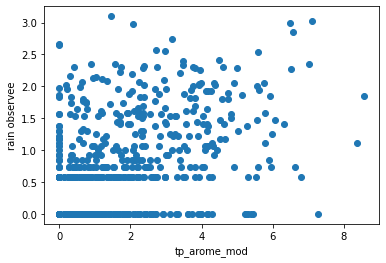

In [279]:
plt.plot(X_train["tp_arome_mod"],Yr_train,"o")
plt.xlabel("tp_arome_mod")
plt.ylabel("rain observee")
plt.show()

In [280]:
#from sklearn.metrics import r2_score
print("R2=",r2_score(Yr_train,X_train["tp_arome_mod"]))

R2= -5.62591088189844


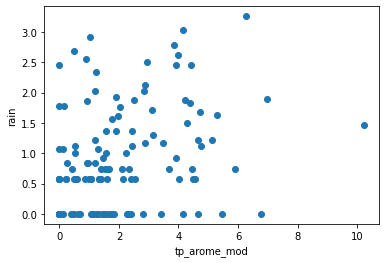

In [281]:
plt.plot(X_test["tp_arome_mod"],Yr_test,"o")
plt.xlabel("tp_arome_mod")
plt.ylabel("rain")
plt.show()

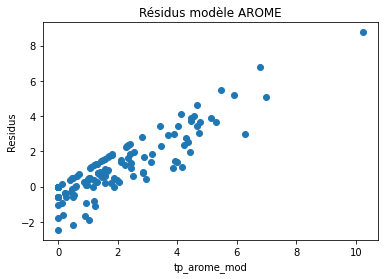

In [282]:
plt.plot(X_test["tp_arome_mod"],X_test["tp_arome_mod"]-Yr_test,"o")
plt.xlabel("tp_arome_mod")
plt.ylabel("Residus")
plt.title("R√©sidus mod√®le AROME")
plt.show()

**Q** Commenter la qualit√© de ces r√©sidus.
- <FONT COLOR="Blue"> Les r√©sidus ne sont pas dispers√©s de fa√ßon √©quivalente. Cela signifie que la variance d√©pend de Y et n'est pas constante (h√©t√©rosc√©dasticit√©). 
- <FONT COLOR="Blue"> On observe une forme particuli√®re (au moins 3 droites parall√®les) dans le nuage donc il y a toujours une tendance ce qui sugg√®re que les r√©sidus ne sont pas ind√©pendants entre eux. 
- <FONT COLOR="Blue"> Il y beaucoup d'outliers 

<FONT COLOR="Blue"> Lorsqu'il y a une droite cela signifie que sur plusieurs donn√©es on a la m√™me valeur pour la quantit√© de pluie r√©elle. En effet les r√©sidus sont obtenus de la mani√®re suivante $\hat \epsilon = Y - \hat Y$ donc si Y est constante, alors on observe une droite. Par exemple, la premi√®re droite  $\hat \epsilon =  - \hat Y $ passe par l'origine du rep√®re donc $Y = 0$ c'est √† dire qu'il n'y a pas de pluie. En effet, on observe dans les donn√©es qu'il y a beaucoup de jours pour lesquels la pluie est nulle.
 

In [283]:
# Erreur quadratique moyenne
print("erreurs pour le mod√®le AROME")
print("--------------------------")
print("MSE=",mean_squared_error(X_test["tp_arome_mod"],Yr_test))
print("MAPE=", MAPE(list(X_test["tp_arome_mod"]),list(Yr_test)))
# Le coefficient de d√©termination 
# peut √™tre n√©gatif en pr√©vision avec un mauvais mod√®le, 
# est nul si la pr√©vision est constante √©gale √† la moyennne
print("R2=",r2_score(Yr_test,X_test["tp_arome_mod"]))

erreurs pour le mod√®le AROME
--------------------------
MSE= 4.08490949153839
MAPE= 41.82100936842558
R2= -4.885981098305556


#### [R√©gression lin√©aire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou mod√®le gaussien

<FONT COLOR = "blue"> Nous allons comparer cette pr√©vision d√©terministe par le mod√®le AROME √† l'adaptation statistique la plus √©l√©mentaire. Il s'agit d'une r√©gression avec choix de mod√®le par r√©gularisation avec une p√©nalisation lasso. 

<FONT COLOR = "blue"> Pour la regression lasso, on ne conserve que les variables quantitatives. On met dans x la variable √† expliquer **rain_mod** et dans y toutes les variables sauf la variable qualitative **date**, **class_rain** et la variable √† expliquer **rain_mod**. 
    
<FONT COLOR="Blue"> En python la valeur par d√©faut en python pour le param√®tre de p√©nalisation ùõº est 1 (on peut le voir en faisant help(linear_model.Lasso))
    
    
<FONT COLOR="Blue">**M√©thode Lasso**
    
<FONT COLOR="Blue">* Objectif d'utilisation de la m√©thode : 
    
   <FONT COLOR="Blue"> Annuler des coefficients du vecteur Œ∏ (vecteurs des param√®tres), en faisant une s√©lection de variables, de mani√®re √† rendre notre mod√®le plus interpr√©table. 
       
<FONT COLOR="Blue">* Variables √† tuner :  
    
<FONT COLOR="Blue">$\lambda$(param√®tre d‚Äôajustement/p√©nalisation) : plus il est faible plus le risque d'overfitting est important, plus il est grand plus un nombre important de variables est annul√©. Nous le tunons gr√¢ce √† la validation crois√©e. \\
    
    




In [284]:
regLasso = linear_model.Lasso(alpha=0)
regLasso.fit(Xr_train,Yr_train)
prev=regLasso.predict(Xr_test)
print("MSE=",mean_squared_error(Yr_test,prev))
print("MAPE=", MAPE(list(Yr_test), prev)) 

MSE= 0.47596944123805457
MAPE= 33.95162148985955


<ipython-input-284-03477803b2e3>:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regLasso.fit(Xr_train,Yr_train)
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.020e+02, tolerance: 3.052e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [285]:
#from sklearn import linear_model
regLasso = linear_model.Lasso()
regLasso.fit(Xr_train,Yr_train)
prev=regLasso.predict(Xr_test)

In [286]:
print("R2=",r2_score(Yr_test,prev))

R2= -0.0001819324448388837


Le param√®tre de p√©nalisation lasso est optimis√© par validation crois√©e.

In [287]:
# grille de valeurs du param√®tre alpha √† optimiser
param=[{"alpha":[0.01,0.02, 0.025,0.03,0.035, 0.04,0.05,0.1,0.2,0.3,0.4,0.5,1,1.3,1.5,1.6,1.7,1.8,2,4]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Yr_train)
# param√®tre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur param√®tre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Meilleur R2 = 0.271601, Meilleur param√®tre = {'alpha': 0.03}


**Q** Quelle validation crois√©e est ex√©cut√©e? <FONT COLOR="Blue"> Il s'agit d'un 5-fold CV. </font>

Pr√©vision avec la valeur optimale de `alpha` puis calcul et trac√© des r√©sidus.

In [288]:
prev=regLassOpt.predict(Xr_test)
print("r√©sultats pour le mod√®le lin√©aire LASSO")
print("-----------------------------------------")
print("MSE=",mean_squared_error(prev,Yr_test))

print("MAPE=", MAPE(list(Yr_test), prev))
print("R2=",r2_score(Yr_test,prev))

r√©sultats pour le mod√®le lin√©aire LASSO
-----------------------------------------
MSE= 0.47389950506691036
MAPE= 34.09869890341539
R2= 0.31715414133454667


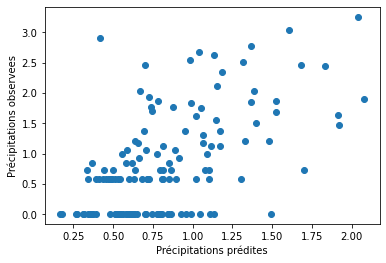

In [289]:
plt.plot(prev,Yr_test,"o")
plt.xlabel(u"Pr√©cipitations pr√©dites")
plt.ylabel("Pr√©cipitations observees")
plt.show()

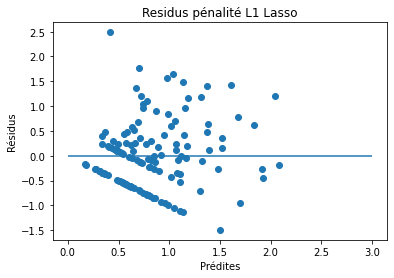

In [290]:
plt.plot(prev,Yr_test-prev,"o")
plt.xlabel(u"Pr√©dites")
plt.ylabel(u"R√©sidus")
plt.title("Residus p√©nalit√© L1 Lasso") 
plt.hlines(0,0,3)
plt.show()

<FONT COLOR="Blue"> **Comparaison avec le mod√®le AROME :** 
    
- **MSE et R¬≤ :** Avec la p√©nalisation L1 de Lasso, on obtient de meilleurs MSE et R¬≤. En effet, un bon mod√®le doit avoir un MSE faible et un R¬≤ proche de 1.      

- **Graphique des r√©sidus :** On remarque un graphe plus ramass√© avec la regression lasso (p√©nalit√© L1). La dispersion des donn√©es sur l'axe des ordon√©es semble identique tandis que la dispersion sur l'axe des abscisses est moins importante avec la p√©nalit√© L1. </font>

L'interpr√©tation n√©cessite de conna√Ætre les valeurs des coefficients du mod√®le alors que l'objet `regLassOpt` issu de `GridSearchCV` ne retient pas les param√®tres estim√©s. Il faut donc le r√©-estimer avec la valeur optimale du param√®tre de p√©nalisation si l'on souhaite afficher ces coefficients.

In [291]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(Xr_train,Yr_train)
model_lasso.coef_

array([-0.        , -0.        ,  0.02264375,  0.01106697,  0.        ,
       -0.01439146, -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.04202933, -0.        ,
        0.        ,  0.        ,  0.12418514, -0.        ,  0.        ,
        0.11845153,  0.07446328, -0.        , -0.        ,  0.        ,
       -0.        , -0.1589435 ])

In [292]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 8 variables et en supprime 19


Text(0.5, 1.0, 'Coefficients du mod√®le lasso')

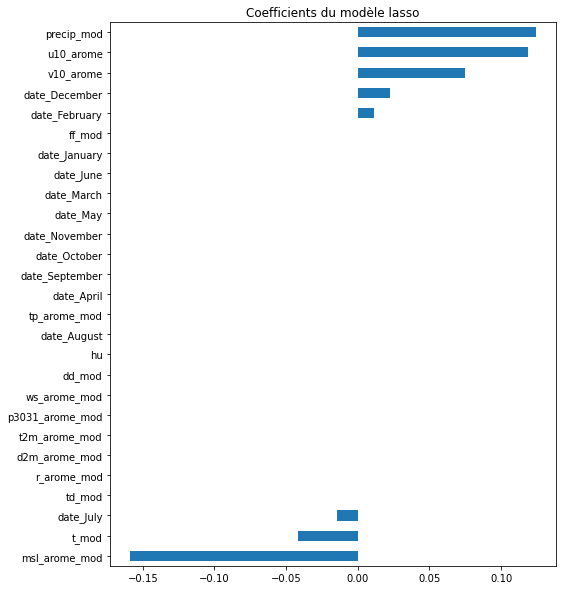

In [293]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du mod√®le lasso")

**Q** Noter les cons√©quences de la p√©nalisation

<FONT COLOR="Blue"> **Effets de la regression LASSO :** 
<FONT COLOR="Blue">- La p√©nalisation Lasso a permi de supprimer un grand nombre de variable. Elle garde 10 variables et en supprime 17. En effet, Lasso permet d'obtenir un estimateur parcimonieux pour rendre le mod√®le plus interpr√©table. 
<FONT COLOR="Blue">- Les param√®tres qui semblent avoir le plus d'influence sur les pr√©cipitations sont *precip_mod*, *u10_arome*, *v10_arome* et *msl_arome_mod*. *t_mod*, date_december et *date_February* ont √©galement √©t√© s√©lectionn√© mais sont d'importance moindre. 
</font> 

<FONT COLOR="Blue">Cela est assez coh√©rent avec le diagramme de corr√©lation qu'on avait trac√© pr√©c√©demment, car on avait que *precip* et*tp_arome* √©taient tr√®s corr√©l√©es, et la s√©lection de variables permet de ne garder que *precip_mod*. De m√™me pour *ws_arome* qui √©tait tr√®s corr√©l√©e avec *precip_mod*, *tp_arome*, *ff_mod*. On ne garde au final que *ws_mod*.


<FONT COLOR="Blue">C'est ici qu'appara√Æt une insuffisance de la librairie python. Il faudrait construire "√† la main" ou utiliser la librairie *Statsmodels* pour afficher les statistiques des tests et p-valeurs. M√™me avec ces compl√©ments, la prise en compte des interactions et de leur s√©lection ne sont pas pr√©vues. De plus l'interpr√©tation est compliqu√©e par l'√©clatement de chaque variable qualitative en paquets d'indicatrices. C'est encore compr√©hensible avec peu de variables mais devient rapidement inexploitable.

*Scikit-learn* propose d'autres proc√©dures d'optimisation du param√®tre de r√©gularisation lasso par validation crois√©e en r√©gression; `lassoCV` utilise un algorithme de *coordinate descent*, sans calcul de d√©riv√©e puisque la norme *l1* n'est pas d√©rivable, tandis que `lassoLarsCV` est bas√©e sur l'algorithme de *least angle regression*. Ces fonctions permettent de tracer √©galement les *chemins de r√©gularisation*. Voici l'exemple de `lassoCV` qui offre plus d'options.

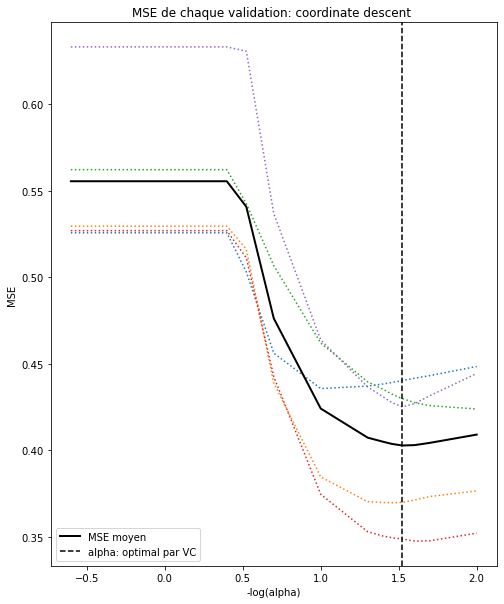

alpha optimal nouvel algo 0.03
alpha optimal trouv√© pr√©c√©demment {'alpha': 0.03}


In [294]:
#from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=[0.01,0.02, 0.025,0.03,0.035, 0.04,0.05,0.1,0.2,0.3,0.4,0.5,1,1.3,1.5,1.6,1.7,1.8,2,4],n_jobs=-1,random_state=13).fit(Xr_train,Yr_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

print("alpha optimal nouvel algo", model.alpha_)
print("alpha optimal trouv√© pr√©c√©demment",regLassOpt.best_params_)

**Q** V√©rifier que c'est bien la m√™me valeur optimale que celle pr√©c√©demment trouv√©e.

Trac√©s des chemins de r√©gularisation.

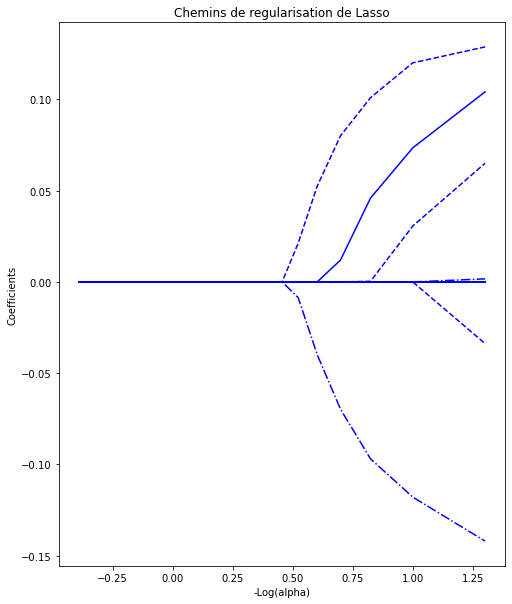

In [295]:
alphas_lasso, coefs_lasso, _ = lasso_path(Xr_train,Yr_train, alphas=np.array(range(1,50,1))/20.,)
plt.figure()
ax = plt.gca()
styles = cycle(['-', '--', '-.', ':'])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, s in zip(coefs_lasso, styles):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle=s,c='b')
    plt.title("Chemins de regularisation de Lasso")
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.show()

<FONT COLOR = "blue"> Ce graphique repr√©sente les chemins de r√©gularisation. $\alpha$ est le param√®tre de p√©nalisation dans la regression LASSO. 
On trace pour chaque valeur de $-log (\alpha)$ en abscisse, l'estimation des param√®tres de notre mod√®le contenus dans le vecteur $\hat \theta$. Chaque courbe est une variable de $\hat \theta$. Lorsque la courbe touche 0, le coefficient correspondant dans $\hat \theta$ s'annule.
    
<FONT COLOR = "blue"> Plus $\alpha$ augmente et plus les param√®tres du vecteur $\hat \theta$ vont √™tre estim√©s √† 0 (pour que le terme de p√©nalisation $l_1$ reste constant). Ainsi, plus $\alpha$ augmente et plus on a de coefficients nuls dans $\hat \theta$ donc plus notre estimateur $\hat \theta$ devient sparse.

#### [R√©gression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf) ou mod√®le binomial

La m√™me d√©marche est d√©roul√©e mais en mod√©lisant directement la variable binaire Yb de d√©passement ou non du seuil. Il s'agit d'une r√©gression logistique avec toujours une p√©nalisation Lasso pour op√©rer une s√©lection de variables.

In [297]:
# Optimisation du param√®tre de p√©nalisation

#Rq : qd la variable √† expliquer est multinomiale, 
#LogisticRegression s√©lectionne par d√©faut le mod√®le multinomiale

param=[{"C":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.5,1.7,2,3,4]}] # grille de valeurs
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(Xr_train, Yb_train)  # GridSearchCV est lui m√™me un estimateur
# param√®tre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.452727, Meilleur param√®tre = {'C': 0.3}


Le mod√®le "optimal"  obtenu est utilis√© pour pr√©dire l'√©chantillon test et estimer ainsi, sans biais, une erreur de pr√©vision. 

La matrice de confusion croise la quantit√© de pluie pr√©dite avec celle effectivement observ√©e. 

In [298]:
y_chap = logitOpt.predict(Xr_test) # Pr√©diction
table=pd.crosstab(y_chap,Yb_test)  # Matrice de confusion
print("Erreurs et performance du mod√®le logistique pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=", 1-logitOpt.score(Xr_test, Yb_test))
print("puret√©=", purity(table))
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))


Erreurs et performance du mod√®le logistique pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.42028985507246375
puret√©= 0.5797101449275363
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          20         9        4
low_rain           13        42       25
no_rain             2         5       18

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.571429
low_rain     0.750000
no_rain      0.382979
dtype: float64


<FONT COLOR = "blue"> **Interpr√©tation matrice de confusion :**
- en colonne : la r√©alit√© 
- en ligne la pr√©diction
    
En comparant les rapports entre les trois lignes, on observe que : 
- Quand on pr√©dit **high_rain** (premi√®re colonne) notre mod√®le n'est pas tr√®s bon car il se trompe presque une fois sur deux en pr√©disant **low_rain**.
- Quand on pr√©dit **low_rain** (deuxi√®me colonne) notre mod√®le est un peu meilleur, il fournit une pr√©diction correcte dans 62% des cas. Il fait √† peu pr√®s le m√™me nombre d'erreur entre **high_rain** et **no_rain** qu'il a pr√©dit respectivement 11 fois et 14 fois.
- Quand on pr√©dit **no_rain** (premi√®re colonne) notre mod√®le n'est pas  bon il ne fournit la bonne pr√©diction que dans 38% des cas. Il pr√©dit m√™me plus de fois **low_rain** que **no_rain**.
   
**Probl√®me de chiffres non?**

L'interpr√©tation du mod√®le est bas√©e sur les valeurs des coefficients avec les m√™mes difficult√©s ou restrictions que pour la r√©gression. Attention, `GridSearch` ne retient pas les coefficients, il faut les r√©-estimer.

In [299]:
# Coefficients
logitLasso=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef=logitLasso.fit(Xr_train,Yb_train).coef_
print(logitCoef[0])

[-0.18900519 -0.00390557  0.17173804  0.02504202  0.15118716 -0.08532969
  0.          0.         -0.03426423  0.14862124  0.01311566 -0.01315979
  0.          0.         -0.23529046  0.          0.          0.26345171
 -0.1134382   0.47196446  0.19979446  0.30631494  0.          0.
  0.         -0.12546149 -0.80413753]


In [300]:
coef = pd.Series(logitCoef[0], index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 18 variables et en supprime 9


Text(0.5, 1.0, 'Coefficients du mod√®le lasso')

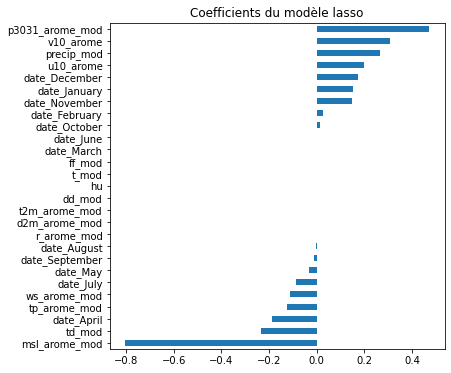

In [301]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du mod√®le lasso")

**Q** Interpr√©ter l'effet des variables retenues.

<FONT COLOR="Blue"> **Effets de la regression LASSO :** 

La p√©nalisation Lasso a permi de supprimer 6 variables et en a conserv√© 20. 

Parmi les param√®tres √©t√© s√©lectionn√©es on remarque notamment :
- **msl_arome_mod** (pression atmosph√©rique) et **p3031_arome_mod** (direction du vent) qui sont les deux variables qui ont le plus d'influence. 
- **date** : Toutes les variables qui concernent les mois ont √©t√© s√©lectionn√©es. Les mois de Novembre et D√©cembre ont un coefficient positif tandis que les autres ont un coefficient n√©gatif. 
- **precip_mod** (quantit√© totale des pr√©cipitations), **tp_arome_mod** (quantit√© totale des pr√©cipitations pr√©dites par le mod√®le AROME) et **v10_arome** (composantes du vent d'ouest √† est prise √† 10m de hauteur) font √©galement partie des variables qui ont le plus d'influence
    
<FONT COLOR="green"> **Effets de la regression LASSO :** 

La p√©nalisation Lasso a permis de supprimer 15 variables et en a conserv√© 12. 

Parmi les param√®tres qui ont √©t√© s√©lectionn√©s, on remarque notamment :
- **msl_arome_mod** (pression atmosph√©rique) et **p3031_arome_mod** (direction du vent) qui sont les deux variables qui ont le plus d'influence. 
- **date** : Les variables qui concernent les mois d'avril, janvier, novembre, d√©cembre ont √©t√© s√©lectionn√©es. Les mois de janvier, Novembre et D√©cembre ont un coefficient positif tandis avril n√©gatif. 
- **precip_mod** (quantit√© totale des pr√©cipitations), **tp_arome_mod** (quantit√© totale des pr√©cipitations pr√©dites par le mod√®le AROME) et **v10_arome** (composantes du vent d'ouest √† est prise √† 10m de hauteur) font √©galement partie des variables qui ont le plus d'influence.
    
On constate que la s√©lection de variables dans le cas de la r√©gression et de la r√©gression logistique on des similitudes (on retrouve u10,v10, precip_mod, t_mod, date_december. 
    Cependant p3031_arome_mod a √©t√© s√©lectionn√© et a un impact important, ce qui peut s'expliquer par le faible nombre de modalit√©s que prend Y (3) dans la r√©gression logistique, que dans la r√©gression avec les variables continues de rain. On a moins d'information quand on utilise une variable qualitative, ce qui peut faire varier la s√©lection de variables ou leur impact (comme msl_arome_mod qui a un impact n√©gatif important dans la r√©gression logistique alors qu'il avait un impact positif moindre dans la r√©gression normale).
    

# <FONT COLOR="Red">√âpisode 2</font>

### [K plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)

Voici un cas d'application d'analyses discriminantes [non param√©triques](http://scikit-learn.org/stable/modules/neighbors.html), celles [param√©triques](http://scikit-learn.org/stable/modules/lda_qda.html) (gaussienes) lin√©aires et quadratiques sont √©galement pr√©sentes dans *scikit-learn* mais laiss√©es en exercice.

Le param√®tre de compl√©xit√© ($k$) est optimis√© sur une grille pr√©d√©finie en minimisant l'erreur estim√©e par validation crois√©e; scikit-learn propose de nombreuses options de validation crois√©e. 

In [58]:
from sklearn.neighbors import KNeighborsClassifier
# Optimisation de k
# grille de valeurs
param_grid=[{"n_neighbors":list(range(1,15))}]
knn=GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knnOpt=knn.fit(Xr_train, Yb_train)  # GridSearchCV est lui m√™me un estimateur
# param√®tre optimal
knnOpt.best_params_["n_neighbors"]
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1.-knnOpt.best_score_,knnOpt.best_params_))

Meilleur score = 0.450909, Meilleur param√®tre = {'n_neighbors': 12}


In [59]:
# Estimation de l'erreur de pr√©vision sur l'√©chantillon test
1-knnOpt.score(Xr_test,Yb_test)

0.5

In [60]:
# Pr√©vision de l'√©chantillon test
y_chap = knnOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print("Erreurs et performance du mod√®le KNN pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=", 1-knnOpt.score(Xr_test,Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du mod√®le KNN pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.5
puret√©= 0.5
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        11        6
low_rain           12        38       29
no_rain             4         7       12

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.678571
no_rain      0.255319
dtype: float64


**Exercice** Compl√©ter les r√©sultats en utilisant la fonction [KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) pour mod√©liser la concentration; optimiser $k$, calculer la pr√©vision de l'√©chantillon test, tracer le graphe des r√©sidus, calculer le MSE sur l'√©chantillon test.

### [Arbre binaire de d√©cision](http://wikistat.fr/pdf/st-m-app-cart.pdf)

#### Utilis√©s en classification pour pr√©dire l'intensit√© de la pluie

<FONT COLOR = "blue">  ***L'utilisation d' arbres binaires de d√©cision*** est une m√©thode qui ne suppose aucune hypoth√®se et est non param√©trique. Ils sont tr√®s interpr√©tables, mais n√©anmoins tr√®s instables de par leur construction, ce qui justifiera l'utilisation de random forest. 

<FONT COLOR = "blue">La premi√®re √©tape consiste √† calculer l'arbre maximal (c'est √† dire l'arbre pour lequel chacune des feuilles ne contient que des valeurs Y homog√®nes). A chaque noeud, on divise selon une variable explicative (et un seuil en r√©gression si la variable explicative est quantitative) qui est choisi tel qu'il minimise la fonction d'h√©t√©rog√©n√©it√© (la somme de l'h√©rog√©n√©it√© du noeud gauche et droit, l'h√©t√©rog√©n√©it√© correspondant √† l'erreur quadratique pour la r√©gression et la Gini concentration ou le crit√®re de la cross entropy en classification) √† chaque noeud. 
    
<FONT COLOR = "blue"> La valeur dans une feuille/noeud terminal de l'arbre correspond √† : 
    
   <FONT COLOR = "blue"> - un vote de majorit√© de toutes les valeurs Y des donn√©es qui sont tomb√©es dans la feuille si on est en CLASSIFICATION 
       
   <FONT COLOR = "blue"> -la moyenne de toutes les valeurs Y des donn√©es qui sont tomb√©es dans la feuille si on est en REGRESSION. 
    
    
<FONT COLOR = "blue">La seconde √©tape est une √©tape d'√©laguage appliqu√©e √† l'arbre complet/maximal. On minimise D(A)+$\gamma$ Nb_feuilles c'est √† dire la somme de l'h√©t√©rog√©n√©it√© dans tout l'arbre en p√©nalisant avec le nombre de feuilles. Cela permet d'√©laguer l'arbre, et l'objectif principal est de d√©couper en deux groupes homog√®nes en terme de classification √† chaque noeud, et de trouver un compromis entre l'arbre maximal et l'arbre constant. 
    
<FONT COLOR = "blue"> Les param√®tres √† optimiser sont la pronfondeur maximale et on l'optimise en faisant de la cross validation pour calculer l'erreur de g√©n√©ralisation. (d'autres param√®tres peuvent aussi √™tre optimis√©s de cette mani√®re tels que le nombre minimal d'observations dans une feuille). 

In [61]:
from sklearn.tree import DecisionTreeClassifier
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOptclass=tree.fit(Xr_train, Yb_train)
# param√®tre optimal

print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - treeOptclass.best_score_,treeOptclass.best_params_))

Meilleur score = 0.498182, Meilleur param√®tre = {'max_depth': 3}


Autre difficult√© dans la repr√©sentation d'un arbre de d√©cision binaire. Le logiciel conseill√© (Graphviz) semble d√©licat d'installation et d'utilisation pour un n√©ophyte. Il est possible de lister la construction des noeuds avec quelques [lignes de commande.](http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

In [62]:
treeG=DecisionTreeClassifier(max_depth=treeOptclass.best_params_['max_depth']) #on optimise ici selon la profondeur
treeG.fit(Xr_train,Yb_train)
treepred=treeG.predict(Xr_test)#on pr√©dit l'√©chantillon test

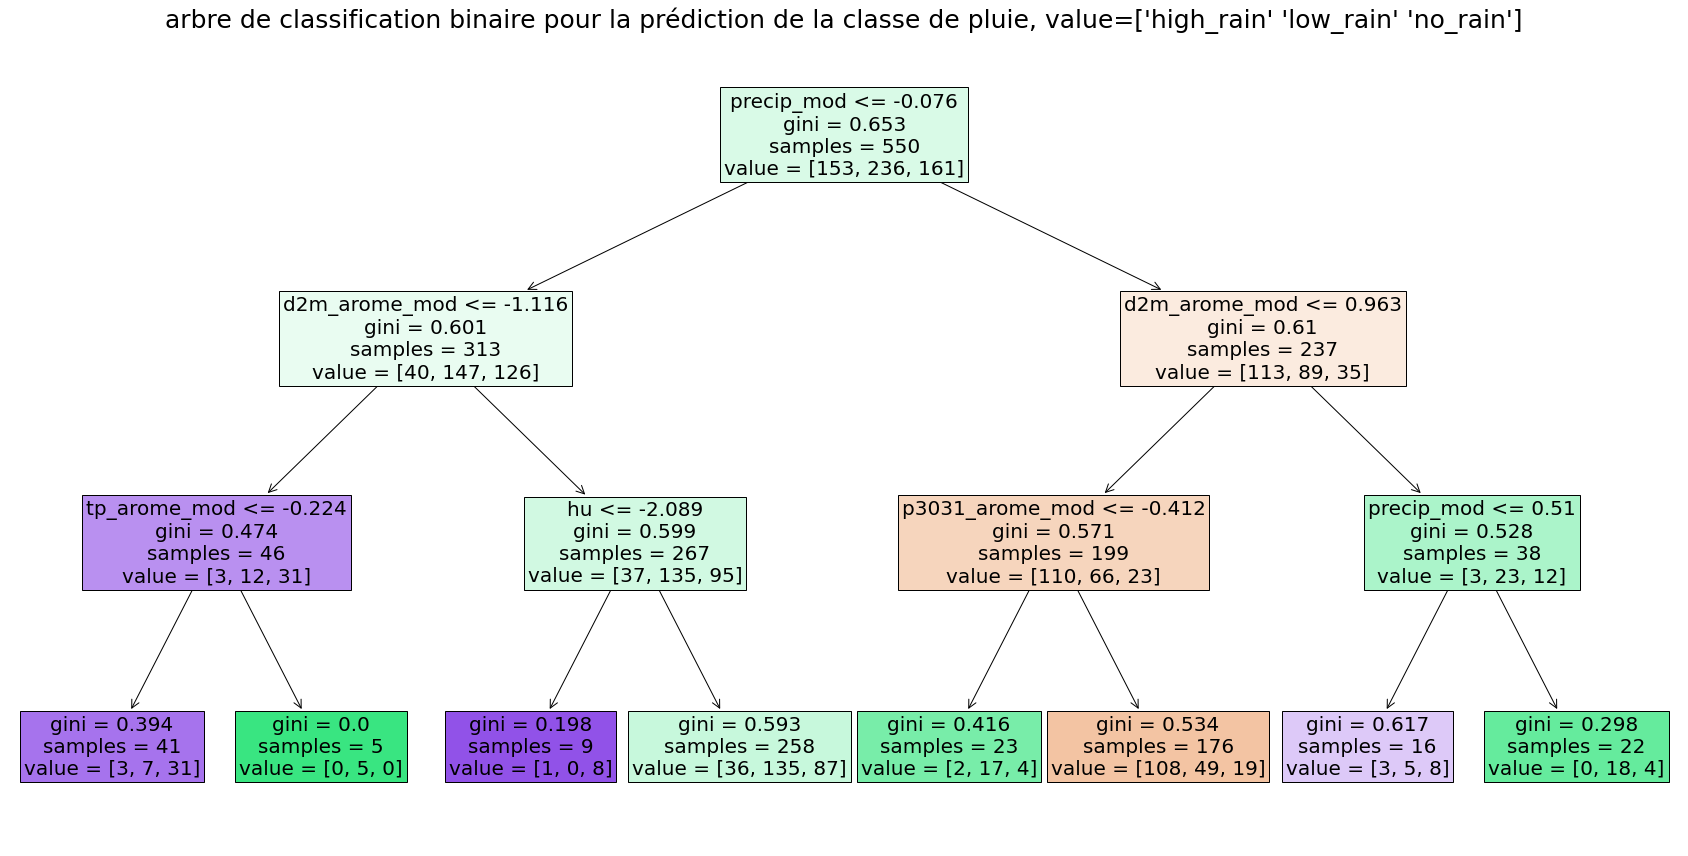

In [63]:
import matplotlib.pyplot as plt
from sklearn import tree
##autre proposition (plus claire pour moi)
plt.figure(figsize=(30,15))
tree.plot_tree(treeG,fontsize=20,feature_names=list(X_train.columns), filled=True)
plt.title("arbre de classification binaire pour la pr√©diction de la classe de pluie, value="+str(np.unique(list(Yb_train))), fontsize=25)
plt.show()

**Q** Que dire de l'interpr√©tation de l'arbre? Comparer les r√¥les des variables avec le mod√®le logit.

<FONT COLOR = "blue">  On obtient l'arbre d√©termin√© en ayant optimis√© la profondeur maximale (ici 3). La variable qui a le plus d'importance est la variable qui a permis d'effectuer le premier split, ici precip_mod, ce qui est normal car elle correspond √† la quantit√© totale des pr√©cipitations. td_mod et d2m arome_mod ont aussi une grande importance (ici il s'agit des points de ros√©e). Value correspond √† un vecteur avec l'effectif de chaque classe ["high_rain", "low_rain", "no_rain"]. On voit qu'on est pas encore √† l'arbre maximal car il y a encore des feuilles o√π il y a une assez grande h√©t√©rog√©n√©it√©. 

In [64]:

treepred
table=pd.crosstab(treepred,Yb_test)  # Matrice de confusion #selon l'ordinateur mettre list(treepred) et list(Yb_test) ou pas
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))



rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        17        7
low_rain           11        35       21
no_rain             5         4       19

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.625000
no_rain      0.404255
dtype: float64


<font color="blue"> On voit que l'arbre semble avoir une meilleure pr√©diction moyenne pour chaque classe par rapport √† logit. 

In [65]:
# pr√©vision de l'√©chantillon test

y_chap = treeOptclass.predict(Xr_test)
# matrice de confusion

table=pd.crosstab(y_chap,Yb_test)
print("Erreurs et performance du mod√®le CART pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=", 1-treeOptclass.score(Xr_test,Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))
print("classe et effectifs")
print(np.unique(Yb_test, return_counts=True))

Erreurs et performance du mod√®le CART pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.47101449275362317
puret√©= 0.5289855072463768
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        17        7
low_rain           11        35       21
no_rain             5         4       19

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.625000
no_rain      0.404255
dtype: float64
classe et effectifs
(array(['high_rain', 'low_rain', 'no_rain'], dtype=object), array([35, 56, 47]))


In [66]:
import re 
from sklearn.tree import export_text
rtreeclass = export_text(treeG.fit(Xr_train,Yb_train), feature_names=list(dfC.columns))
print("affichage d' un r√©sum√© de la construction de l'arbre plus lisible")
print(rtreeclass)

affichage d' un r√©sum√© de la construction de l'arbre plus lisible
|--- precip_mod <= -0.08
|   |--- d2m_arome_mod <= -1.12
|   |   |--- tp_arome_mod <= -0.22
|   |   |   |--- class: no_rain
|   |   |--- tp_arome_mod >  -0.22
|   |   |   |--- class: low_rain
|   |--- d2m_arome_mod >  -1.12
|   |   |--- hu <= -2.09
|   |   |   |--- class: no_rain
|   |   |--- hu >  -2.09
|   |   |   |--- class: low_rain
|--- precip_mod >  -0.08
|   |--- d2m_arome_mod <= 0.96
|   |   |--- p3031_arome_mod <= -0.41
|   |   |   |--- class: low_rain
|   |   |--- p3031_arome_mod >  -0.41
|   |   |   |--- class: high_rain
|   |--- d2m_arome_mod >  0.96
|   |   |--- precip_mod <= 0.51
|   |   |   |--- class: no_rain
|   |   |--- precip_mod >  0.51
|   |   |   |--- class: low_rain



#### Utilis√©s en r√©gression : pr√©dire la quantit√© de pluie rain

In [67]:
param=[{"max_depth":list(range(1,10))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOptr=tree.fit(Xr_train, Yr_train)
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - treeOptr.best_score_,treeOptr.best_params_))

Meilleur score = 0.856855, Meilleur param√®tre = {'max_depth': 2}


In [68]:
treeR=DecisionTreeRegressor(max_depth=treeOptr.best_params_['max_depth']) #on optimise ici selon la profondeur
treeR.fit(Xr_train,Yr_train)
dot_data = StringIO() 
export_graphviz(treeR, out_file=dot_data) 
graph=pydotplus.graph_from_dot_data(dot_data.getvalue()) 
#graph.write_png("treeOpt.png")  

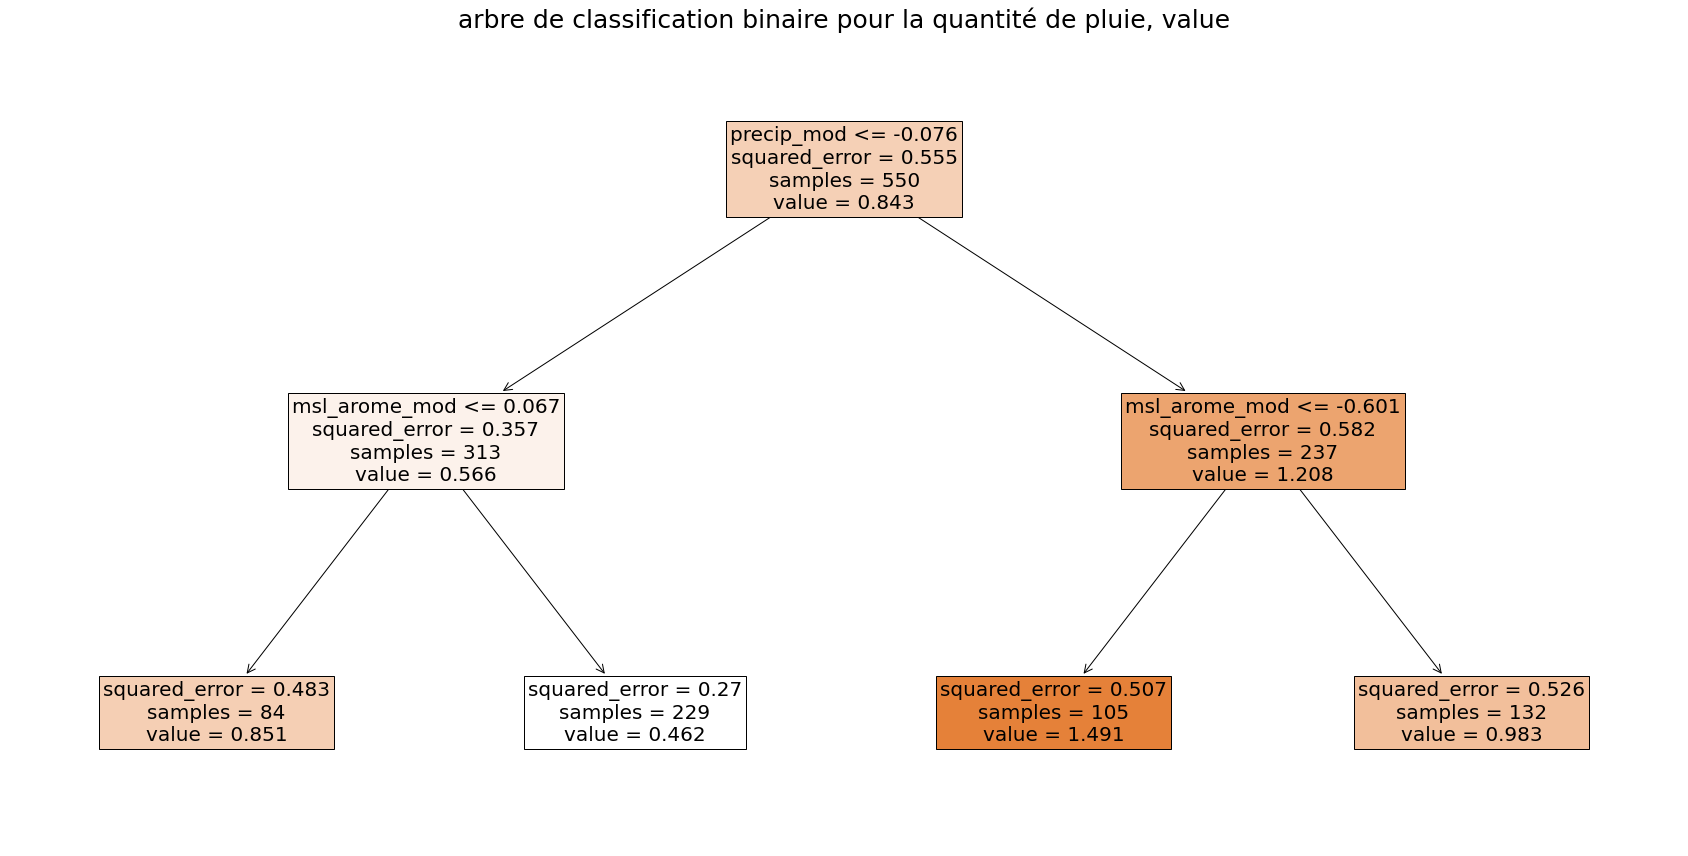

In [69]:
import matplotlib.pyplot as plt
from sklearn import tree #autre possibilit√©
##autre proposition (plus claire pour moi)
plt.figure(figsize=(30,15))
tree.plot_tree(treeR,fontsize=20,feature_names=list(X_train.columns), filled=True)
plt.title("arbre de classification binaire pour la quantit√© de pluie, value", fontsize=25)
plt.show()

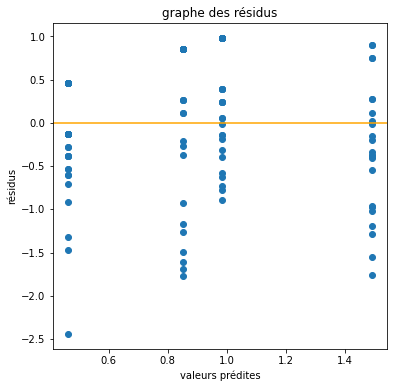

In [70]:
treepredreg=treeR.predict(Xr_test)#on pr√©dit l'√©chantillon test
treeres=treepredreg-list(Yr_test)#r√©sidus 
plt.plot(treepredreg,treeres, "o") 
plt.title ("graphe des r√©sidus")
plt.ylabel("r√©sidus")
plt.xlabel("valeurs pr√©dites")
plt.axhline(c="orange")

In [71]:
print("Erreurs et performance du mod√®le CART pour pr√©dire la quantit√© de pr√©cipitations ici Rain_mod")
print("-------------------------------------------------------------------")
print("MSE=",mean_squared_error(Yr_test,treepredreg))
print("MAPE=", MAPE(list(Yr_test), treepredreg))
print("erreur g√©n√©ralisation Python = ", 1-treeOptr.score(Xr_test,Yr_test))

Erreurs et performance du mod√®le CART pour pr√©dire la quantit√© de pr√©cipitations ici Rain_mod
-------------------------------------------------------------------
MSE= 0.5200324138890837
MAPE= 36.65441854042261
erreur g√©n√©ralisation Python =  0.7493191623946147


<font color="blue"> La structure particuli√®re du graphe est due au fait que les pr√©dictions sont constantes par morceaux. Il y a autant de pr√©dictions que de feuilles/noeuds terminaux. Cela explique la forme stri√©e du graphe (en abscisse chaque valeur correspond √† la valeur d'un noeud terminal). Cela peut amplifier l'erreur, est explique le fait que les r√©sidus ne sont pas tous tr√®s proches de 0. La variance varie √©galement un peu.  C'est ici que random forest peut avoir un avantage important car il permettra de faire des pr√©dictions avec plusieurs arbres et de moyenner la sortie. 

In [72]:
mseregarbre=np.sum(( treepredreg-list(Yr_test))**2) /len(treepredreg) #calcul du mse

In [73]:
class_tree_post_regression=np.ones((np.shape(treepredreg)[0],1))
class_tree_post_regression[np.where(treepredreg>2)]=2
class_tree_post_regression[np.where(treepredreg==0)]=0
#no_rain (si rain=0), -low_rain (si 0<rain<2), -high_rain (si rain>2)

In [74]:

rtreeReg= export_text(treeR.fit(Xr_train,Yr_train), feature_names=list(dfC.columns))
print("affichage d' un r√©sum√© de la construction de l'arbre plus lisible")
print(rtreeReg)

affichage d' un r√©sum√© de la construction de l'arbre plus lisible
|--- precip_mod <= -0.08
|   |--- msl_arome_mod <= 0.07
|   |   |--- value: [0.85]
|   |--- msl_arome_mod >  0.07
|   |   |--- value: [0.46]
|--- precip_mod >  -0.08
|   |--- msl_arome_mod <= -0.60
|   |   |--- value: [1.49]
|   |--- msl_arome_mod >  -0.60
|   |   |--- value: [0.98]



### M√©thodes d'agr√©gation

#### [For√™ts al√©atoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

La librairie *randomForest* de R utilise le programme historique d√©velopp√© par [Breiman et Cutler](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_software.htm)(2001) et interfac√©  par [Liaw et Wiener](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf). Cette interface est toujours mise √† jour mais il n'est pas s√ªr que le programme original continue d'√©voluer depuis 2004. Pour des tailles importantes d'√©chantillons, quelques milliers, cette impl√©mentation atteint des temps d'ex√©cution r√©dhibitoires (cf. cet [exemple](https://github.com/wikistat/Ateliers-Big-Data/blob/master/2-MNIST/Atelier-MNIST-R.ipynb)) au contraire de celle en Python dont gestion m√©moire et capacit√© de parall√©lisation ont √©t√© finement optimis√©es par [Louppe et al.](http://fr.slideshare.net/glouppe/accelerating-random-forests-in-scikitlearn)(2014). 

De m√™me que le boosting, deux fonctions  de for√™t sont propos√©s dans [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html) ; une pour la r√©gression et une pour la classification ainsi qu'une version "plus al√©atoire". Par rapport √† la version originale de R, moins d'options sont propos√©es mais l'utilisation de base est tr√®s similaire avec le m√™me jeu de param√®tres.

**Q20** Identifier les param√®tres, les valeurs par d√©faut.

<font color="blue"> Principe du `random forest` : Cette technique permet de r√©duire l'instabilit√© du mod√®le CART. Elle met en oeuvre une technique de bootstrapping de mani√®re √† tirer al√©atoirement et avec remise B √©chantillons de taille n, de mani√®re √† construire B arbres CART. A chaque noeud, m parmi les p variables explicatives $(m<p)$ sont choisies a√©atoirement, et le split ne peut se faire qu'en fonction d'elles. Cela permet de choisir des variables de s√©paration, qui n'auraient pas √©t√© choisies car il y en aurait eu des meilleurs sinon, et permet aussi d'obtenir une diversit√© d'arbres.Ensuite on fait une √©tape d'agr√©gation c'est √† dire que pour chaque x_0 qu'on souhaite pr√©dire, on pr√©dit pour chaque arbre la valeur $\hat{Y}$ (comme pour les arbres). Ensuite, en classification, on fait un vote de majorit√© parmi tous les $\hat{Y}$. Sinon, si on est en r√©gression on fait la moyenne entre tous les $\hat{Y}$ pr√©dits par les B arbres.

<font color="blue"> Rappel sur les out of bag : individus qui n'ont pas √©t√© tir√©s dans l'√©tape de bootstrapping. On peut calculer l'erreur de g√©n√©ralisation gr√¢ce √† cela. 

<font color="blue">  Variables √† param√©trer : nombre d'arbres, profondeur maximale, nombre minimal et maximal d'individus dans une feuille, le nombre de features m qui peut etre chosii √† chaque noeud.... Elles peuvent √™tre optimis√©es par cross validation (ou aussi en utilisant l'erreur de g√©n√©ralisation obtenue par l'out of bag error). 


##### Utilisation des randoms forest dans un contexte de classification 

In [75]:
from sklearn.ensemble import RandomForestClassifier 
# d√©finition des param√®tres
forest = RandomForestClassifier(n_estimators=500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
#une technique de boostrap est mise en oeuvre de mani√®re √† construire 500 arbres, 
#gini est utilis√© comme crit√®re d'h√©t√©rog√©n√©it√© et l'out of bag score est renvoy√©
# apprentissage
rfFit = forest.fit(Xr_train,Yb_train)
print("OOB error", 1-rfFit.oob_score_) #Return the error of generalisation (1-accuracy) ATTENTION

OOB error 0.5018181818181818


Comparer l'erreur out-of-bag ci-dessus avec celle sur l'√©chantillon test.

In [76]:
# erreur de pr√©vision sur le test
1-rfFit.score(Xr_test,Yb_test)

0.4347826086956522

Optimisation par validation crois√©e du nombre de variables tir√©s al√©atoirement lors de la construction de chaque noeud. 

In [77]:
param=[{"max_features":list(range(2,10,1)), "n_estimators":np.arange(100,300,100)}]
rf= GridSearchCV(RandomForestClassifier(),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, Yb_train)
# param√®tre optimal
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.472727, Meilleur param√®tre = {'max_features': 2, 'n_estimators': 100}


Plusieurs ex√©cutions, rendues al√©atoires par la validation crois√©e, peuvent conduire √† des valeurs "optimales" diff√©rentes de ce param√®tre sans pour autant nuire √† la qualit√© de pr√©vision sur l'√©chantillon test.

In [78]:
# pr√©vision
y_chap = rfFit.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)

print("Erreurs et performance du mod√®le RF pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=",1-rfOpt.score(Xr_test,Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du mod√®le RF pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.4347826086956522
puret√©= 0.5652173913043478
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        11        5
low_rain           14        38       21
no_rain             2         7       21

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.678571
no_rain      0.446809
dtype: float64


Comme avec R, il est possible de calculer un indicateur d'importance des variables pour aider √† une forme d'interpr√©tation. Celui-ci d√©pend de la position de la variable dans l'arbre et correspond donc au *mean decrease in Gini index* de R plut√¥t qu'au *mean descrease in accuracy*. La for√™t doit √™tre r√©estim√©e car GridSearch ne conna√Æt pas le param√®tre d'importance.

In [79]:
rf= RandomForestClassifier(n_estimators=100,max_features=2)
rfFit=rf.fit(Xr_train, Yb_train)
# Importance d√©croissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(Xr_train.shape[1]):
    #print(f)
    print(dfC.columns[indices[f]], importances[indices[f]])

msl_arome_mod 0.07894066312851199
u10_arome 0.06358476926189445
p3031_arome_mod 0.06336976506072652
t2m_arome_mod 0.06193026836987526
hu 0.06146550904960364
d2m_arome_mod 0.06130606243566381
v10_arome 0.06117862939567252
tp_arome_mod 0.06089461593603957
r_arome_mod 0.06089359117226672
precip_mod 0.05983491593799916
t_mod 0.05849088623396938
ws_arome_mod 0.058332119906347214
dd_mod 0.05734924628344437
td_mod 0.056058709281085556
ff_mod 0.05566783637054889
date_January 0.009115528564086059
date_November 0.008477111426639893
date_April 0.007606969818632411
date_March 0.007260786377058609
date_August 0.00701868455106768
date_May 0.006503475372660959
date_June 0.006397044096658251
date_September 0.0060836997563839205
date_July 0.0058621881998173085
date_October 0.0056147544660963555
date_February 0.005573529589247995
date_December 0.0051886399580014534


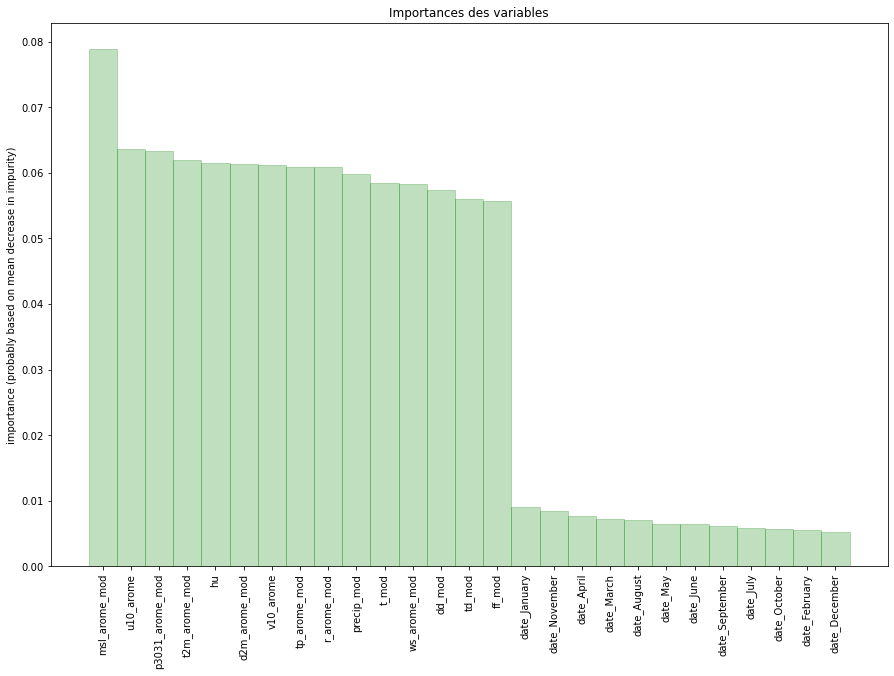

In [80]:
# Graphe des importances
plt.figure(figsize=((15,10)))
plt.bar(list(dfC.columns[indices]), importances[indices] ,1, color='g', edgecolor="g", alpha=0.25)
plt.title("Importances des variables")
plt.ylabel("importance (probably based on mean decrease in impurity)")
plt.xticks(rotation=90)
plt.show()

**Q** Comparer les importances des variables et les s√©lections op√©r√©es pr√©c√©demment. 

<font color="blue"> Dans Python, le crit√®re d'importance est la Gini importance. Ils sont calcul√©s apr√®s avoir construit notre foret (car on ne peut pas comme pour les arbres prendre la variable le plus en haut car on a plusieurs arbres). On prend la variable qui la plus grand importance. Ici, il s'agit de msl.arome_mod correspondant √† la pression atmosph√©rique pr√©dite par le mod√®le de m√©t√©o france (variable qui n'avait pas √©t√© choisie par l'arbre mais qui a √©t√© choisie ici gr√¢ce au tirage al√©atoire de m variable √† chaque noeud). 

**Exercice** Remplacer ensuite la fonction RandomForestClassifier par celle [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de r√©gression. Optimiser le param√®tre, calculer la pr√©vision, les r√©sidus, le MSE.

**Exercice** Exp√©rimenter √©galement le boosting sur ces donn√©es en ex√©cutant la fonction [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) op√©rant l'agorithme de *gradient tree boosting*. 

**Remarque:** Une version "am√©lior√©e" de *boosting* mieux paral√©lis√©e et incluant d'autres param√®tres (p√©nalisation), est  propos√© dans le package: [`XGBoost`](https://xgboost.readthedocs.io/en/latest/build.html#python-package-installation) qui peut √™tre utilis√© √† partir de Python mais aussi R, Julia ou Java. N√©namoins le choix est fait d'arr√™ter l'acharnement sur ces donn√©es; `XGBoost` est test√© en python sur un autre jeu de donn√©es. 

##### Utilisation des random forest en r√©gression

In [81]:
from sklearn.ensemble import RandomForestRegressor
# d√©finition des param√®tres
forest = RandomForestRegressor(n_estimators=500, 
    max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFitreg = forest.fit(Xr_train,Yr_train) 
print("erreur out of bag", 1-rfFitreg.oob_score_) #on calcule l'erreur out of bag. 

erreur out of bag 0.7470090310964465


<font color="blue">  Avec calibration des param√®tres par cross validation 5 folds

In [82]:
param=[{"n_estimators":[100,500,1000], "max_features":list(range(2,10,1)), "max_depth":list(range(2,10,1))}]#optimisation de m, correspondant √† max_features, noeudmbde de variabl
rf= GridSearchCV(RandomForestRegressor(bootstrap=True),
        param,cv=5,n_jobs=-1)
rfOptreg=rf.fit(Xr_train, Yr_train)
# param√®tre optimal
print("Erreur = %f, Meilleur param√®tre = %s" % (1. - rfOptreg.best_score_,rfOptreg.best_params_))

Erreur = 0.742592, Meilleur param√®tre = {'max_depth': 8, 'max_features': 5, 'n_estimators': 500}


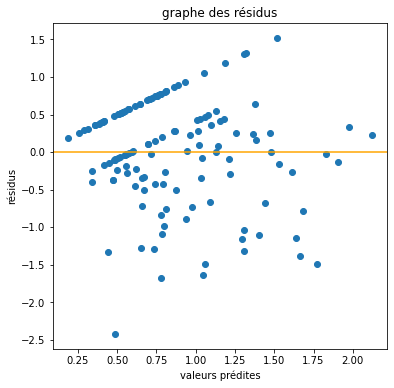

In [83]:
rfregpred=rfOptreg.predict(Xr_test)#on pr√©dit l'√©chantillon test
treeres=rfregpred-list(Yr_test)#r√©sidus 
plt.plot(rfregpred,treeres, "o") 
plt.title ("graphe des r√©sidus")
plt.ylabel("r√©sidus")
plt.xlabel("valeurs pr√©dites")
plt.axhline(c="orange")

In [84]:
mserfreg=np.sum((rfregpred-list(Yr_test))**2) /len(rfregpred) #calcul du mse, √† v√©irfier 

print("Erreurs et performance du mod√®le RF pour pr√©dire la quantit√© de pr√©cipitations ici Rain_mod")
print("-------------------------------------------------------------------")
print("MSE=",mean_squared_error(Yr_test,rfregpred))
print("MAPE=", MAPE(list(Yr_test), rfregpred))

print("erreur g√©n√©ralisation Python = ", 1-rfOptreg.score(Xr_test,Yr_test))

Erreurs et performance du mod√®le RF pour pr√©dire la quantit√© de pr√©cipitations ici Rain_mod
-------------------------------------------------------------------
MSE= 0.4737893342713723
MAPE= 34.4705345062054
erreur g√©n√©ralisation Python =  0.6826871126218835


In [85]:
rfOptregbis=RandomForestRegressor(bootstrap=True, max_depth=rfOptreg.best_params_["max_depth"], max_features=rfOptreg.best_params_["max_features"], n_estimators=rfOptreg.best_params_["n_estimators"])
rfOptreg.best_params_

{'max_depth': 8, 'max_features': 5, 'n_estimators': 500}

In [86]:
# Importance d√©croissante des variables

rfOptregbis.fit(Xr_train, Yr_train)
importancesreg = rfOptregbis.feature_importances_
indicesreg = np.argsort(importancesreg)[::-1]
for f in range(Xr_train.shape[1]):
    print(dfC.columns[indicesreg[f]], importances[indicesreg[f]])

msl_arome_mod 0.07894066312851199
precip_mod 0.05983491593799916
tp_arome_mod 0.06089461593603957
v10_arome 0.06117862939567252
u10_arome 0.06358476926189445
ws_arome_mod 0.058332119906347214
p3031_arome_mod 0.06336976506072652
dd_mod 0.05734924628344437
ff_mod 0.05566783637054889
t_mod 0.05849088623396938
td_mod 0.056058709281085556
t2m_arome_mod 0.06193026836987526
hu 0.06146550904960364
d2m_arome_mod 0.06130606243566381
r_arome_mod 0.06089359117226672
date_February 0.005573529589247995
date_April 0.007606969818632411
date_January 0.009115528564086059
date_May 0.006503475372660959
date_November 0.008477111426639893
date_December 0.0051886399580014534
date_September 0.0060836997563839205
date_March 0.007260786377058609
date_June 0.006397044096658251
date_August 0.00701868455106768
date_July 0.0058621881998173085
date_October 0.0056147544660963555


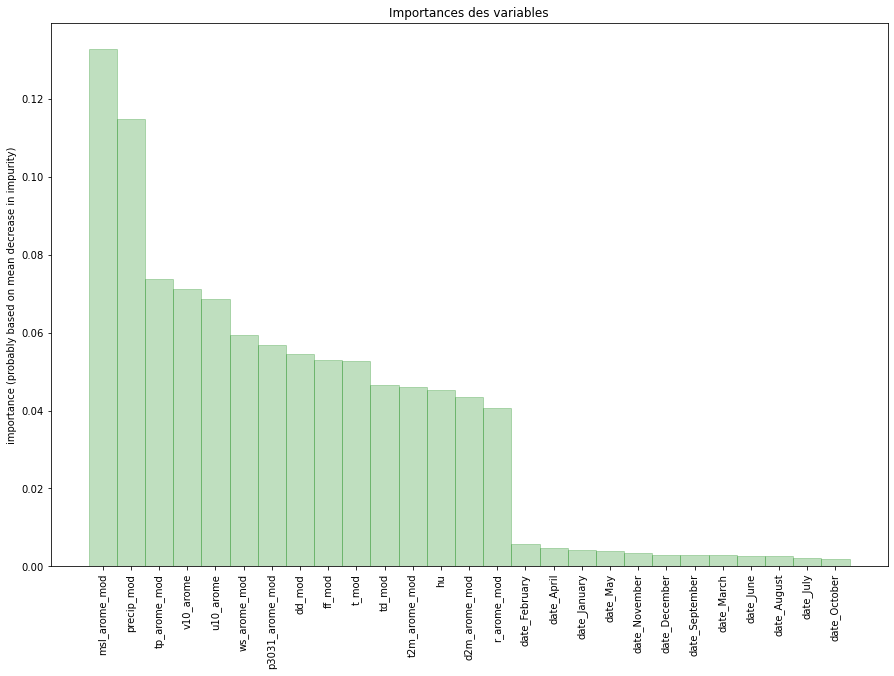

In [87]:
plt.figure(figsize=((15,10)))
plt.bar(list(dfC.columns[indicesreg]), importancesreg[indicesreg],1, color='g', edgecolor="g", alpha=0.25)
plt.title("Importances des variables")
plt.ylabel("importance (probably based on mean decrease in impurity)")
plt.xticks(rotation=90)
plt.show()

#### M√©thode de boosting 

<font color="blue"> Une autre mani√®re de faire de l'agr√©gation de mod√®les est d'utiliser le boosting. Il s'agit de r√©aliser une combinaison lin√©aire d'une s√©quence r√©cursive de pr√©dicteurs faibles o√π chaque pr√©dicteur, pond√©r√© par un certain poids, est une version adapt√©e du pr√©dicteur pr√©c√©dent. L'aggr√©gation permet r√©duire la variance et le biais des pr√©dicteurs. A chaque √©tape n des poids plus importants sont mis sur les donn√©es qui ont mal √©t√© pr√©dits par le pr√©dicteur n-1
    
    
<font color="blue">L'algorithme historique Adaboost est d√©di√© √† la classification binaire et minimise une fonction perte exponentielle. Le Gradient Boosting Models  (GBM) est une am√©lioration d' Adaboost. Cet algorithme repose toujours sur une agr√©gation de pr√©dicteurs o√π chaque pr√©dicteur agr√©g√© constitue une √©tape conduisant √† une am√©lioration de la pr√©diction. La diff√©rence r√©side dans le fait que cette √©tape est faite en direction du gradient de la fonction perte, le gradient √©tant lui-m√™me approxim√© par un arbre de r√©gression. Cette m√©thode s'applique aussi bien en r√©gression qu'en classification. 
Pour l'algorithme GBM, param√®tres √† calibrer sont :
    
<font color="blue">- La valeur du  shrinkage. Le shrinkage permet d'√©viter le surajustement en redimensionnant la contribution de chaque arbre intervenant dans GBM par un facteur $\nu$ 
- <font color="blue">La profondeur de l'arbre √† calibrer par cross-validation
- <font color="blue"> Le nombre d'it√©rations $M$. En effet, chaque it√©ration de l'algorithme de boosting r√©duit la perte empirique et une valeur de $M$ trop importante m√®ne √† du surajustement. Une fa√ßon de calibrer ce param√®tre est d'estimer l'erreur de g√©n√©ralisation sur un √©chantillon de validation (par exemple en utilisant la validation crois√©e) et de choisir la valeur de $M$ qui minimise cette erreur ou de faire de l'early stopping c'est √† dire interrompre l'entra√Ænement d'un mod√®le quand la perte d'un ensemble de donn√©es de validation commence √† augmenter et que les performances sur le test se d√©gradent.

##### Classification

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [89]:
# long
param=[{"learning_rate":[0.0001+i*0.001 for i in range (0,15)],"max_depth":np.arange(2,6,1)}]#optimisation de max depth et du learning rate
clfOpt = GridSearchCV(GradientBoostingClassifier(n_estimators=75, random_state=0, loss= "deviance"),  param, cv=5).fit(Xr_train,Yb_train)
print(clfOpt.score(Xr_test,Yb_test))
print("erreur g√©n√©ralisation la plus basse = %f, Meilleur param√®tre = %s" % (clfOpt.best_score_,clfOpt.best_params_))

0.6086956521739131
erreur g√©n√©ralisation la plus basse = 0.503636, Meilleur param√®tre = {'learning_rate': 0.0091, 'max_depth': 4}


In [90]:
y_chap =clfOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print("Erreurs et performance du mod√®le Boosting pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=",1-clfOpt.score(Xr_test, Yb_test))#Return the error of generalisation (1-accuracy) ATTENTION
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))
# pr√©vision

Erreurs et performance du mod√®le Boosting pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.3913043478260869
puret√©= 0.6086956521739131
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19         7        4
low_rain           13        44       22
no_rain             3         5       21

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.785714
no_rain      0.446809
dtype: float64


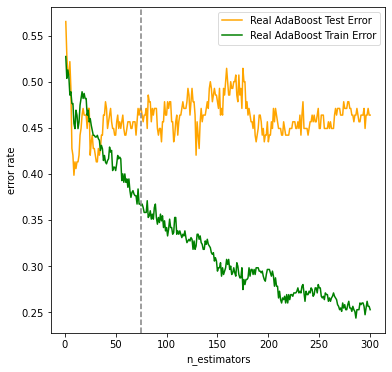

In [91]:
n_estimators = 300
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.0

from sklearn.metrics import zero_one_loss
ada_real = AdaBoostClassifier(
    
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)

ada_real.fit(Xr_train, Yb_train)
fig = plt.figure()
ax = fig.add_subplot(111)



ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(Xr_test)):
    ada_real_err[i] = zero_one_loss(y_pred, Yb_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(Xr_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, Yb_train)

ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="Real AdaBoost Test Error",
    color="orange",
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="Real AdaBoost Train Error",
    color="green",
)


ax.set_xlabel("n_estimators")
ax.set_ylabel("error rate")
plt.axvline(x=75,color='gray',linestyle='--')
leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

<font color="blue"> On utilise la m√©thode d'early stopping, on prend l√† o√π le courbe est minimale pour le test et ou √ßa commence √† diverger entre les 2 courbes pour √©viter l‚Äôoverfitting. On fixe donc le nombre de pr√©dicteurs/nombre d'it√©rations √† 75, juste avant la divergence entre les deux courbes.

<font color="blue"> Maintenant qu'on a d√©termin√© le nb d'estimateurs (√©quivalent au nombre d'arbres) d√©terminons le learning rate optimal et la profondeur d'arbres optimale, arbres construit √† chaque √©tape du boosting. 

In [92]:
param=[{"learning_rate":np.linspace(0.0001, 0.5,5), "n_estimators":np.arange(1, 600, 100)}]#optimisation de m
clf= GridSearchCV(AdaBoostClassifier(),
        param,cv=5,n_jobs=-1)
clfOptada=clf.fit(Xr_train, Yb_train)

# param√®tre optimal
print("erreur g√©n√©ralisation la plus basse = %f, Meilleur param√®tre = %s" % (1. - clfOptada.best_score_,clfOptada.best_params_))

erreur g√©n√©ralisation la plus basse = 0.492727, Meilleur param√®tre = {'learning_rate': 0.125075, 'n_estimators': 101}


<font color ="blue"> On choisit ici par early stopping le nombre d'estimateurs (le nombre d'arbres) et on voit que prendre n\_estimateurs=50 a lieu juste avant la divergence des deux courbes

In [93]:
predictions = clfOpt.predict(Xr_test)
predictions
from sklearn.metrics import classification_report
print(classification_report(Yb_test,clf.predict(Xr_test)))

              precision    recall  f1-score   support

   high_rain       0.67      0.69      0.68        35
    low_rain       0.53      0.73      0.61        56
     no_rain       0.75      0.38      0.51        47

    accuracy                           0.60       138
   macro avg       0.65      0.60      0.60       138
weighted avg       0.64      0.60      0.59       138



In [94]:
clf.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__algorithm': 'SAMME.R',
 'estimator__base_estimator': None,
 'estimator__learning_rate': 1.0,
 'estimator__n_estimators': 50,
 'estimator__random_state': None,
 'estimator': AdaBoostClassifier(),
 'n_jobs': -1,
 'param_grid': [{'learning_rate': array([1.00000e-04, 1.25075e-01, 2.50050e-01, 3.75025e-01, 5.00000e-01]),
   'n_estimators': array([  1, 101, 201, 301, 401, 501])}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [95]:
param=[{"learning_rate":np.linspace(0.0001, 1,20)}]#optimisation de m
clf= GridSearchCV(AdaBoostClassifier( n_estimators=70),
        param,cv=5,n_jobs=-1)
clfOptada=clf.fit(Xr_train, Yb_train)

In [96]:
print(1-clfOptada.score(Xr_train, Yb_train))

0.43272727272727274


##### Regression

<font color="blue"> Optimisation par early stopping du nombre de pr√©dicteurs (ici d'abres utilis√©s)

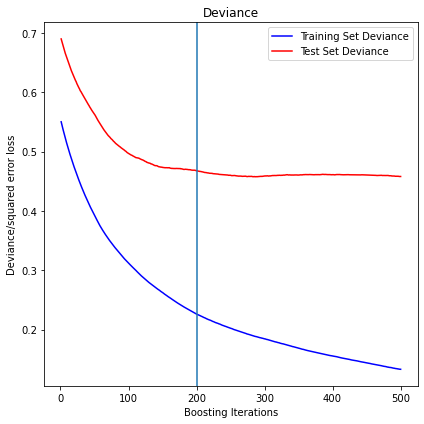

In [97]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(**params)
reg.fit(Xr_train, Yr_train)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

for i, y_pred in enumerate(reg.staged_predict(Xr_test)):
    test_score[i] = reg.loss_(Yr_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)

#plt.axvline((np.arange(params["n_estimators"]) + 1)[np.argmin(test_score)])
plt.axvline(200)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance/squared error loss")
fig.tight_layout()
plt.show()



<font color="blue"> On utilise la m√©thode d'early stopping, on prend l√† o√π le courbe est minimale pour le test et ou ca commence √† diverger entre les 2 courbes pour √©viter l‚Äôoverfitting. On fixe donc le nombre de pr√©dicteurs/nimbre d'it√©rations √† 200, juste avant la divergence entre les deux courbes. 

In [98]:
# d√©finition des param√®tres

# apprentissage
from sklearn.ensemble import GradientBoostingRegressor


param=[{"learning_rate":[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1], "max_depth": np.arange(2,20,3)}]#optimisation de m
rf= GridSearchCV(GradientBoostingRegressor(n_estimators=200),
        param,cv=5,n_jobs=-1)
boostOpt=rf.fit(Xr_train, Yr_train)

# param√®tre optimal
print("Error la moins √©lev√©e = %f, Meilleur param√®tre = %s" % (1. -boostOpt.best_score_,boostOpt.best_params_)) #1-R^2

Error la moins √©lev√©e = 0.755120, Meilleur param√®tre = {'learning_rate': 0.02, 'max_depth': 2}


##### Comparaison des for√™ts al√©atoires, arbres, boosting  

In [99]:
print("Erreurs et performance du mod√®le Boosting pour pr√©dire Rain_mod")
print("-------------------------------------------------------------------")

print("erreur g√©n√©ralisation en Python= ", 1-boostOpt.score(Xr_test, Yr_test))
boostpred=boostOpt.predict(Xr_test)
mseboostreg=np.sum(( boostpred-list(Yr_test))**2) /len(boostpred) 
print("MSE= ", mserfreg)
print("MAPE = ",MAPE(boostpred, list(Yr_test)))

Erreurs et performance du mod√®le Boosting pour pr√©dire Rain_mod
-------------------------------------------------------------------
erreur g√©n√©ralisation en Python=  0.6633254771042226
MSE=  0.4737893342713723
MAPE =  29.0336784429097


In [100]:
rfpredcalcul=rfOptreg.predict(Xr_test)
treeRcalcul=treeR.predict(Xr_test)
ar = np.array([[list(map(str, rtreeclass.split('\n', 1)[0].split()))[1],1-treeOptclass.score(Xr_test,Yb_test),"_","_"],[list(map(str, rtreeReg.split('\n', 1)[0].split()))[1],1-treeR.score(Xr_test,Yr_test),mseregarbre, MAPE(treeRcalcul,list(Yr_test))], [dfC.columns[indicesreg][0], 1-rfOptreg.score(Xr_test, Yr_test), mserfreg,  MAPE(rfpredcalcul,list(Yr_test))], [dfC.columns[indices][0], 1-rfFit.score(Xr_test,Yb_test), "_", "_"],["_",1-boostOpt.score(Xr_test, Yr_test),mseboostreg, MAPE(boostpred, list(Yr_test))],["_",1-clfOpt.score(Xr_test, Yb_test),"_", "_"], ["_",1-clfOptada.score(Xr_test, Yb_test),"_", "_"]])
df = pd.DataFrame(ar, index = ["Tree Classification", "Tree r√©gression", 'Random forest regression', 'Random Forest classification', 'boosting r√©gression', 'Gradient boosting classification', 'Ada Boosting classification'], columns = ['variable la plus importante', 'erreur de g√©n√©ralisation sur le test', "mse", "MAPE"])
df

variable la plus importante  \
Tree Classification                               precip_mod   
Tree r√©gression                                   precip_mod   
Random forest regression                       msl_arome_mod   
Random Forest classification                   msl_arome_mod   
boosting r√©gression                                        _   
Gradient boosting classification                           _   
Ada Boosting classification                                _   

                                 erreur de g√©n√©ralisation sur le test  \
Tree Classification                               0.47101449275362317   
Tree r√©gression                                    0.7493191623946147   
Random forest regression                           0.6826871126218835   
Random Forest classification                      0.46376811594202894   
boosting r√©gression                                0.6633254771042226   
Gradient boosting classification                   0.3913043478260869   
Ada Boosting classification                       0.42028985507246375   

                                                  mse                MAPE  
Tree Classification                                 _                   _  
Tree r√©gression                    0.5200324138890837  31.682167016102106  
Random forest regression           0.4737893342713723  29.164699230728058  
Random Forest classification                        _                   _  
boosting r√©gression               0.46035223221873944    29.0336784429097  
Gradient boosting classification                    _                   _  
Ada Boosting classification                         _                   _

<font color="blue"> Par le tableau, on voit que les erreurs sur l'√©chantillon test sont moins importantes dans le cas de la r√©gression que dans le cas de la classification. Les arbres et les for√™ts dans le cadre de la classification sont dans notre cas tr√®s peu performants, le mod√®le n'arrivant pas bien √† faire des pr√©dictions.  
Pour comparer les m√©thodes CART et les m√©thodes d'agr√©gation, on voit tout d'abord que la variable la plus importante n'est pas la m√™me pour les deux types de mod√®les. Que ce soit en classification ou en r√©gression pour les arbres CART, precip_mod est conserv√©e, il s'agit de la quantit√© totale des pr√©cipitations du jour j. Rain_class et rainmod √©tant les pr√©visions de pr√©cipitations du jour suivant, cela semble normal. 
    
<font color="blue"> Que ce soit en classfication ou en r√©gression pour les random forest, la pression atmosph√©rique pr√©dite par m√©t√©o France (en P a) (msl_arome_mod) est conserv√©e. La variable la plus importante est donc la pression atmosph√©rique pr√©dite pour le jour suivant qui aurait un impact sur les pr√©cipitations le lendemain. Msl_arome_mod est une variable qui est tr√®s corr√©l√©e avec un grand nombre de variables explicatives (comme precip mod) comme on l'avait vu pr√©c√©demment dans le graphe des corr√©lations. C'est aussi une variable qui avait √©t√© conserv√©e dans le mod√®le de r√©gression p√©nalis√© avec Lasso. 

<font color="blue"> On remarque que les erreurs sont plus importantes avec les mod√®les agr√©g√©s qu'avec les mod√®les d'arbre. Cela est surprenant car les arbres sont particuli√®rement instables, alors que les random forest, gr√¢ce aux techniques de boostrapping et de s√©lection de variables al√©atoires √† chaque noeud permet de mieux prendre en compte l'ensemble des variables et de faire diminuer la variance. 

# <FONT COLOR="Red">√âpisode 3</font>

### [R√©seau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

Les r√©seaux neuronaux (perceptron multicouche) ne sont pr√©sents dans le package `Scikit-learn` qu'√† partir de la version 0.18. Les m√©thodes *profondes* (*deep learning*) n√©cessitent l'installation des librairies [*theano*](http://deeplearning.net/software/theano/) et [*Lasagne*](http://lasagne.readthedocs.io/en/latest/index.html) ou [*theano*](http://deeplearning.net/software/theano/), [*TensorFlow*](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html) et [*Keras*](https://keras.io/). Ces derni√®res sont nettement plus complexes √† installer, surtout sous Windows. Elles feront l'objet d'un autre tutoriel.

#### Classification 

In [101]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

D√©finition des param√®tres dont le nombre de neurones et `alpha` qui r√®gle la r√©gularisation par d√©faut 10-5. Le nombre de neurones est optimis√© mais ce peut √™tre `alpha` avec un nombre grand de neurones. Le nombre max d'it√©rations par d√©faut (200) semble insuffisant. Il est fix√© √† 500.

In [102]:
#exemple d'utilisation 
#For architecture 56:25:11:7:5:3:1 with input 56 and 1 output hidden layers will be (25:11:7:5:3). 
#So tuple hidden_layer_sizes = (25,11,7,5,3,)
param_grid=[{"hidden_layer_sizes":list([(2), (3), (4,),(5,),(6,),(7,),(8,),(9,),(10,)]), "alpha": [5,10]}]
nnet= GridSearchCV(MLPClassifier(max_iter=1500, activation='logistic'),param_grid,cv=10,n_jobs=-1) 


In [103]:
nnetOptclas=nnet.fit(Xr_train, Yb_train)
# param√®tre optimal, 1-mean(accuracy)
print("Erreur la plus basse = %f, Meilleur param√®tre = %s" % (1. - nnetOptclas.best_score_,nnetOptclas.best_params_))

Erreur la plus basse = 0.474545, Meilleur param√®tre = {'alpha': 5, 'hidden_layer_sizes': (8,)}


In [104]:
nneclass =MLPClassifier(random_state=1, max_iter=500, alpha=nnetOptclas.best_params_["alpha"],hidden_layer_sizes=nnetOptclas.best_params_["hidden_layer_sizes"]).fit(Xr_train, Yb_train)

In [105]:
# pr√©vision de l'√©chantillon test
y_chap = nneclass.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)

print("Erreurs et performance du mod√®le R√©seau de neurones pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=",1-nnetOptclas.score(Xr_test,Yb_test))
print("score accuracy Python = ", accuracy_score(nneclass.predict(Xr_test),Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du mod√®le R√©seau de neurones pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.47101449275362317
score accuracy Python =  0.5507246376811594
puret√©= 0.5507246376811594
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          18         9        4
low_rain           14        37       22
no_rain             3        10       21

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.514286
low_rain     0.660714
no_rain      0.446809
dtype: float64


**Exercice** Remplacer ensuite la fonction MLPClassifier par celle [MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de r√©gression. Optimiser le param√®tre, calculer la pr√©vision, les r√©sidus, le MSE.

#### R√©gression 

In [106]:
from sklearn.neural_network import MLPRegressor
param_grid=[{"hidden_layer_sizes":list([(1,), (2,), (3,), (4,), (5,),(6,),(7,),(8,), (9,), (10,)]), "alpha":[5,10]}]
nnet= GridSearchCV(MLPRegressor(max_iter=1500),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(Xr_train, Yr_train)
# param√®tre optimal
print("Erreur la plus basse = %f, Meilleur param√®tre = %s" % (1. - nnetOpt.best_score_,nnetOpt.best_params_))

Erreur la plus basse = 0.736408, Meilleur param√®tre = {'alpha': 10, 'hidden_layer_sizes': (4,)}


erreur :  0.734632977009619


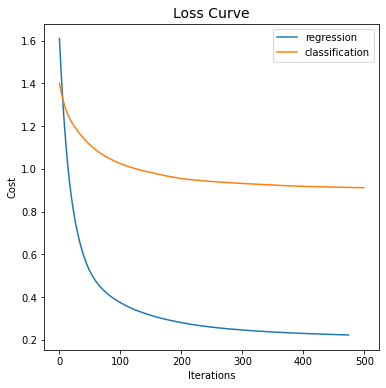

In [107]:
print("erreur : ", 1-nnetOpt.score(Xr_test,Yr_test))

regr = MLPRegressor(random_state=1, max_iter=1500, alpha=nnetOpt.best_params_["alpha"],hidden_layer_sizes=nnetOpt.best_params_["hidden_layer_sizes"]).fit(Xr_train, Yr_train)

plt.plot(regr.loss_curve_, label="regression")
plt.plot(nneclass.loss_curve_, label="classification")
plt.legend()
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

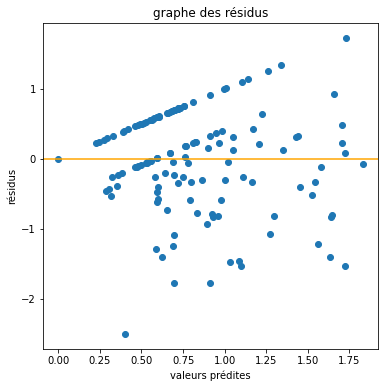

In [108]:
rnnpred=nnetOpt.predict(Xr_test)
rnnres=rnnpred-list(Yr_test)#r√©sidus 
plt.plot(rnnpred,rnnres, "o") 
plt.title ("graphe des r√©sidus")
plt.ylabel("r√©sidus")
plt.xlabel("valeurs pr√©dites")
plt.axhline(c="orange")

In [109]:
print("Erreurs et performance du mod√®le R√©seaux de Neurones pour pr√©dire Rain_mod")
print("-------------------------------------------------------------------")
msernnreg=np.sum(( rnnpred-list(Yr_test))**2) /len(rnnpred) 
print("MSE = ", msernnreg)
print("MAPE= ",MAPE(rnnpred, list(Yr_test)))

Erreurs et performance du mod√®le R√©seaux de Neurones pour pr√©dire Rain_mod
-------------------------------------------------------------------
MSE =  0.5098401048973115
MAPE=  30.48624973249136


# <FONT COLOR="Red">√âpisode 4</font>

### [*Support Vector Machine*](http://wikistat.fr/pdf/st-m-app-svm.pdf)

#### Classification 

De nombreux param√®tres sont associ√©s √† cette m√©thode. La liste est √† consulter dans la [documentation](http://scikit-learn.org/stable/modules/svm.html) en ligne.

L'optimisation de la p√©nalisation (param√®tre C) est recherch√©e sur une grille par validation crois√©e. Remarque: il serait n√©cessaire d'optimiser √©galement la valeur du coefficient *gamma* li√© au noyau gaussien ("√©cart-type").

Il est souvent n√©cessaire de normaliser des donn√©es avant d'op√©rer les SVM.

In [110]:
y_true = np.array(Yr_test).tolist() #A utiliser pour la fonction MAPE

In [111]:
from sklearn.svm import SVC
param=[{"C":[0.6,0.8,1.35,1.4,1.45,1.8,2.0,2.2]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train, Yb_train)
# param√®tre optimal
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.436364, Meilleur param√®tre = {'C': 0.8}


<FONT COLOR = "blue"> Le meilleur param√®tre est C=0.8

In [112]:
# pr√©vision de l'√©chantillon test
y_chap = svmOpt.predict(Xr_test) # Pr√©diction
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 
print("Erreurs et performance du mod√®le SVM pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=",1-svmOpt.score(Xr_test,Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du mod√®le SVM pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.46376811594202894
puret√©= 0.5362318840579711
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          16         7        3
low_rain           16        42       28
no_rain             3         7       16

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.457143
low_rain     0.750000
no_rain      0.340426
dtype: float64


<FONT COLOR = "blue"> **Interpr√©tation matrice de confusion :**
- en colonne : la r√©alit√© 
- en ligne la pr√©diction
    
En comparant les rapports entre les trois lignes, on observe que : 
- Quand on pr√©dit **high_rain** notre mod√®le bas√© sur SVM est meilleur que la r√©gression logistique (**cf. autres mod√®les apr√®s avoir fait les √©pisodes 2 et 3**) car ses pr√©dictions sont correctes dans 60% des cas. Cependant, ce r√©sultat reste faible car il se trompe dans 40% des cas avec la variable **low_rain**. 
- Quand on pr√©dit **low_rain** notre mod√®le est assez bon car il fournit une pr√©diction correcte dans 82% des cas. Il √©prouve plus de difficult√©s √† d√©cider entre **high_rain** ou **low_rain** lorsque la bonne pr√©diction est **low_rain**. 
- Quand on pr√©dit **no_rain** notre mod√®le est mauvais car il ne pr√©dit correctement que 20% des cas. Ce r√©sultat est encore plus mauvais que celui de la r√©gression logistique notamment (**cf. autres mod√®les apr√®s avoir fait les √©pisodes 2 et 3**).

In [113]:
from sklearn import svm
#LINEAR kernel
param=[{"C":[0.005,0.01,0.02,0.03,0.04,0.05,0.06]}]
svmL= GridSearchCV(svm.SVC(kernel="linear"),param,cv=10,n_jobs=-1)
svmLOpt=svmL.fit(Xr_train, Yb_train)
# param√®tre optimal
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - svmLOpt.best_score_,svmLOpt.best_params_))

Meilleur score = 0.429091, Meilleur param√®tre = {'C': 0.03}


In [114]:
# erreur test 
y_chap = svmLOpt.predict(Xr_test) # Pr√©diction
# matrice de confusion
print("score",svmLOpt.score(Xr_test, Yb_test))
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 
print("Erreurs et performance du mod√®le SVM noyau lin√©aire pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=",1-svmLOpt.score(Xr_test,Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

score 0.5072463768115942
Erreurs et performance du mod√®le SVM noyau lin√©aire pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.49275362318840576
puret√©= 0.5072463768115942
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          17         7        4
low_rain           14        44       34
no_rain             4         5        9

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.485714
low_rain     0.785714
no_rain      0.191489
dtype: float64


In [115]:
#POLYNOMIAL kernel
param=[{"C":[0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],"gamma":[0.02,0.04,0.06,0.08,0.1]}]
svm_poly=GridSearchCV(svm.SVC(kernel="poly"),param,cv=10,n_jobs=-1)
svm_polyOpt=svm_poly.fit(Xr_train, Yb_train)
# param√®tre optimal
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - svm_polyOpt.best_score_,svm_polyOpt.best_params_))

Meilleur score = 0.472727, Meilleur param√®tre = {'C': 0.03, 'gamma': 0.1}


In [116]:
y_chap = svm_polyOpt.predict(Xr_test) # Pr√©diction
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 

print("Erreurs et performance du mod√®le SVM noyau polynomial pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=",1-svm_polyOpt.score(Xr_test,Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du mod√®le SVM noyau polynomial pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.46376811594202894
puret√©= 0.5362318840579711
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          17         8        4
low_rain           18        44       30
no_rain             0         4       13

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.485714
low_rain     0.785714
no_rain      0.276596
dtype: float64


In [117]:
#RADIAL (RBF) kernel
param=[{"C":[0.4,0.5,0.6,0.7,0.8,0.9,10,20,30],"gamma":[0.005,0.01,0.02,0.3,0.4]}]
svm_rbf=GridSearchCV(svm.SVC(kernel="rbf"),param,cv=10,n_jobs=-1)
svm_rbfOpt=svm_rbf.fit(Xr_train, Yb_train)
# param√®tre optimal
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - svm_rbfOpt.best_score_,svm_rbfOpt.best_params_))

Meilleur score = 0.434545, Meilleur param√®tre = {'C': 10, 'gamma': 0.005}


In [118]:
y_chap = svm_rbfOpt.predict(Xr_test) # Pr√©diction
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 

print("Erreurs et performance du mod√®le SVM noyau gaussien pour pr√©dire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'√©chantillon test
print("erreur sur l'√©chantillon test=",1-svm_rbfOpt.score(Xr_test,Yb_test))
print("puret√©=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de pr√©dictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du mod√®le SVM noyau gaussien pour pr√©dire Rain_class
-------------------------------------------------------------------
erreur sur l'√©chantillon test= 0.44202898550724634
puret√©= 0.5579710144927537
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          16         7        4
low_rain           15        43       25
no_rain             4         6       18

 ratio de pr√©dictions correctes par classe :
rain_class
high_rain    0.457143
low_rain     0.767857
no_rain      0.382979
dtype: float64


<FONT COLOR = "blue"> D'apr√®s les r√©sultats ci-dessous, les meilleurs mod√®les sont dans l'ordre radial/polynomial puis lin√©aire. 

**Exercice** Comme pr√©c√©demment, remplacer ensuite la fonction SVC par celle [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) de r√©gression. Optimiser le param√®tre, calculer la pr√©vision, les r√©sidus; le MSE.

#### R√©gression

In [119]:
from sklearn.svm import SVR
param=[{"C":[0.1,0.2,0.3,0.4,0.5,0.6,0.7],"gamma":[0.005,0.01,0.02,0.3,0.4]}]
svr= GridSearchCV(SVR(),param,cv=10,n_jobs=-1)
svrOpt=svr.fit(Xr_train, Yr_train)
# param√®tre optimal
print("Meilleur score = %f, Meilleur param√®tre = %s" % (1. - svrOpt.best_score_,svrOpt.best_params_))

Meilleur score = 0.723781, Meilleur param√®tre = {'C': 0.6, 'gamma': 0.02}


In [120]:
# pr√©vision de l'√©chantillon test
y_chap = svrOpt.predict(Xr_test) # Pr√©diction

In [121]:
#meteo.loc[483]["rain_mod"]
y_true = np.array(Yr_test).tolist()
print('erreurs Python du mod√®le SVM r√©gression ')
print("--------------------------------------------")
print("erreur g√©n√©ralisation Python =",1-svrOpt.score(Xr_test,Yr_test))
print("MSE=",mean_squared_error(y_chap,Yr_test))
print("MAPE=", MAPE(y_true, y_chap))

erreurs Python du mod√®le SVM r√©gression 
--------------------------------------------
erreur g√©n√©ralisation Python = 0.6732717639841261
MSE= 0.46725502055643525
MAPE= 33.31114723307034


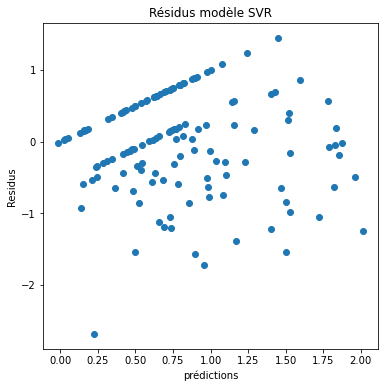

In [122]:
plt.plot(y_chap,y_chap-y_true,"o")
plt.xlabel("pr√©dictions")
plt.ylabel("Residus")
plt.title("R√©sidus mod√®le SVR")
plt.show()

## Synth√®se: comparaison des m√©thodes

### It√©ration sur plusieurs √©chantillons de test ([validation crois√©e *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf))

L'√©chantillon test est de taille modeste et donc l'estimation de l'erreur de pr√©vision peut pr√©senter une variance importante. Celle-ci est r√©duite en op√©rant une forme de validation crois√©e (*Monte Carlo*) en tirant plusieurs couples d'√©chantillon apprentissage et test pour it√©rer les traitements pr√©c√©dents. Les donn√©es sont normalis√©es pour toutes les m√©thodes car les autres que SVM et NN ne sont pas affect√©es.

Les fonctionnalit√©s de scikit-learn se pr√®tent bien √† l'automatisation de ces traitements encha√Ænant extraction d'√©chantillons, estimation de plusieurs mod√®les, optimisation de leurs param√®tres et estimation de l'erreur de pr√©vision sur le test.

Le code est compact et d'ex√©cution efficace car bien parall√©lis√© par les fonctions utilis√©es.

In [123]:
from sklearn.utils import check_random_state
import time
check_random_state(13)
tps0=time.perf_counter()
# d√©finition des estimateurs
logit= LogisticRegression(penalty="l1",solver="liblinear")
knn  = KNeighborsClassifier()
tree = DecisionTreeClassifier()
nnet = MLPClassifier(max_iter=10000)
rf   = RandomForestClassifier(n_estimators=100)
svm  = SVC()
# Nombre d'it√©rations
B=30 # pour ex√©cuter apr√®s le test, mettre plut√¥t B=30
# d√©finition des grilles de param√®tres0
listMethGrid=[[svm,{"C":[0.4,0.5,0.6,0.8,1,1.4]}],
    [rf,{"max_features":list(range(2,10,2))}],
    [nnet,{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}],
    [tree,{"max_depth":list(range(2,10))}],
    [knn,{"n_neighbors":list(range(1,15))}],
    [logit,{"C":[0.5,1,5,10,12,15,30]}]]
# Initialisation √† 0 des erreurs pour chaque m√©thode (colonne) et chaque it√©ration (ligne)
arrayErreur=np.empty((B,6))
for i in range(B):   # it√©rations sur B √©chantillons test
    # extraction apprentissage et test
    X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200)
    scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    # Meme transformation sur le test
    X_test = scaler.transform(X_test)
    # optimisation de chaque m√©thode et calcul de l'erreur sur le test
    for j,(method, grid_list) in enumerate(listMethGrid):
        methodGrid=GridSearchCV(method,grid_list,cv=10,n_jobs=-1).fit(X_train, Yb_train)
        methodOpt = methodGrid.best_estimator_
        methFit=methodOpt.fit(X_train, Yb_train)
        arrayErreur[i,j]=1-methFit.score(X_test,Yb_test)
        y_chap=methFit.predict(X_test)
tps1=time.perf_counter()
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","NN","Tree","Knn","Logit"])    

/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Temps execution en mn : 1651.3232702700002


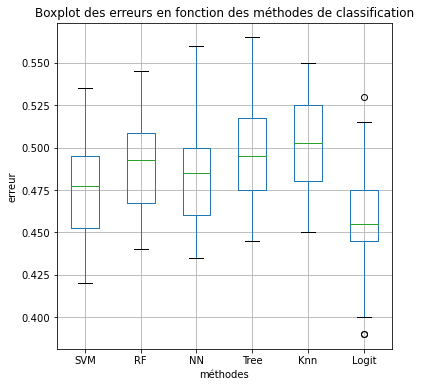

In [124]:
# Distribution des erreurs de pr√©visions
# Les SVM pr√©sentant des erreurs atypiques sont laiss√©s de c√¥t√©.
dataframeErreur[["SVM","RF","NN","Tree","Knn","Logit"]].boxplot(return_type='dict')
plt.ylabel('erreur')
plt.xlabel('m√©thodes')
plt.title("Boxplot des erreurs en fonction des m√©thodes de classification")
plt.show()

Au vu des r√©sultats on choisirait la m√©thode Logit ou svm

In [125]:
# Moyennes
dataframeErreur.mean()

SVM      0.477833
RF       0.489500
NN       0.485500
Tree     0.495833
Knn      0.500833
Logit    0.456333
dtype: float64

In [126]:
from sklearn.utils import check_random_state
import time
from sklearn.neighbors import KNeighborsRegressor
check_random_state(13)
tps0=time.perf_counter()
# d√©finition des estimateurs
reglasso= linear_model.Lasso()
tree = DecisionTreeRegressor()
nnet = MLPRegressor(max_iter=1000, alpha=5)
rf   = RandomForestRegressor(n_estimators=100)
svm  = SVR()
# Nombre d'it√©rations
B=30 # pour ex√©cuter apr√®s le test, mettre plut√¥t B=30
# d√©finition des grilles de param√®tres0
listMethGrid=[[svm,{"C":[0.4,0.5,0.6,0.8,1,1.4]}],
    [rf,{"max_features":list(range(2,10,2))}],
    
    [nnet,{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}],
    [tree,{"max_depth":list(range(2,10))}],
    [reglasso,{"alpha":[0.01,0.02, 0.025,0.03,0.035, 0.04,0.05,0.1,0.2,0.3,0.4,0.5,1,1.3,1.5,1.6,1.7,1.8,2,4]}]]
# Initialisation √† 0 des erreurs pour chaque m√©thode (colonne) et chaque it√©ration (ligne)
arrayErreur=np.empty((B,5))
arraymape=np.empty((B,5))
for i in range(B):   # it√©rations sur B √©chantillons test
    # extraction apprentissage et test
    X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=200)
    scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    # Meme transformation sur le test
    X_test = scaler.transform(X_test)
    # optimisation de chaque m√©thode et calcul de l'erreur sur le test
    for j,(method, grid_list) in enumerate(listMethGrid):
        methodGrid=GridSearchCV(method,grid_list,cv=10,n_jobs=-1).fit(X_train, Yr_train)
        methodOpt = methodGrid.best_estimator_
        methFit=methodOpt.fit(X_train, Yr_train)
        arrayErreur[i,j]=1-methFit.score(X_test,Yr_test)
        Ypredict=methFit.predict(X_test)
        arraymape[i,j]=MAPE(list(Yr_test), Ypredict)
tps1=time.perf_counter()
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","NN","Tree", "reglasso"])    

KeyboardInterrupt: 

In [ ]:
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","NN","Tree", "reglasso"])  
# Distribution des erreurs de pr√©visions
# Les SVM pr√©sentant des erreurs atypiques sont laiss√©s de c√¥t√©.
dataframeErreur[["SVM","RF","NN","Tree", "reglasso"]].boxplot(return_type='dict')
plt.ylabel('erreur')
plt.xlabel('m√©thodes r√©gression')
plt.title("Boxplot des erreurs en fonction des m√©thodes")
plt.show()



MAPE(list(tparome_original), list(meteorain_original))

In [ ]:
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arraymape,columns=["SVM","RF","NN","Tree", "reglasso"])  
# Distribution des erreurs de pr√©visions
# Les SVM pr√©sentant des erreurs atypiques sont laiss√©s de c√¥t√©.
dataframeErreur[["SVM","RF","NN","Tree",  "reglasso"]].boxplot(return_type='dict')
plt.ylabel('erreur MAPE')
plt.xlabel('m√©thodes r√©gression')
plt.title("Boxplot des erreurs en fonction des m√©thodes r√©gression")
plt.show()

print("pour comparaison avec le mod√®le de pr√©diction de base de M√©t√©o France on voit qu'il y a quand meme une am√©lioration du MAPE")
MAPE(list(tparome_original), list(meteorain_original))

### Conclusion sur l'apprentissage
**Q** Quel m√©thode retenir? Est-ce coh√©rent avec les r√©sultats e R?

Cet exemple, trait√© en R puis en Python, r√©sume bien l'int√©r√™t et le contexte des m√©thodes d'apprentissage.
* Par rapport √† la *base line* : pr√©vision MOCAGE pr√©sentant un taux moyen d'erreur de 30%, un mod√®le statistique √©l√©mentaire am√©liore tr√®s sensiblement le r√©sultat.
* Une m√©thode plus sophistiqu√©e, ici *SVM* ou *random forest* apporte une am√©lioration statistiquement significative mais assez faible au prix de l'interpr√©tation fine des r√©sultats fournie par une r√©gression logistique.
* Python, outil d'*apprentissage machine*, est plus efficace que R pour les  simulations.
* En revanche, R, outil d'*apprentissage statistique*, permet la s√©lection et l'interpr√©tation des variables et de leurs **interactions** pour un mod√®le de r√©gression lin√©aire ou logistique classique. La prise en compte d'interactions (mod√®le quadratique) am√©liore sensiblement la qualit√© des pr√©visions.
* Les for√™ts al√©atoires et les SVM font mieux sur cet exemple, c'est souvent le cas comme avec le *boosting*, mais d'autres exemples mettent en avant d'autres m√©thodes: neurones pour une mod√©lisation physique, SVM pour du criblage virtuelle de mol√©cules, r√©gression PLS pour la spectrom√©trie en proche infra-rouge (NIR)... pas de r√®gle g√©n√©rale.
* Jupyter est un support p√©dagogique efficace pour des analyses sans d√©veloppement volumineux de code.
* Avant d'√©ventuellement passer √† [Julia](http://julialang.org/), R et Python sont √† l'usage tr√®s compl√©mentaires.


# <FONT COLOR="Red">√âpisode 5</font>
**Remarque** Il est possible d'ex√©cuter directement l'*√©pisode 5* sans passer par toutes les √©tapes de classification supervis√©e. Il suffit d'ex√©cuter jusqu'√† la *section 4.1* de l'*√©pidode 1*, phase exploratoire et pr√©paration des √©chantillons, afin de construire les donn√©es utilis√©es dans les sections 12 et 13 d'imputation des donn√©es manquantes et de d√©tection d'atypiques.

## [Gestion des donn√©es manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf)
Les vraies donn√©es sont le plus souvent mit√©es par l'absence de donn√©es, cons√©quences d'erreurs de saisie, de pannes de capteurs... Les librairies de Python (`pandas`) offrent des choix rudimentaires pour faire des imputations de donn√©es manquantes quand celles-ci le sont de fa√ßon compl√®tement al√©atoire. 

Le [calepin R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) d'analyse de ces m√™mes donn√©es propose une comparaison assez d√©taill√©e de deux strat√©gi√©es afin d'√©valuer leurs performances respectives. 

La **premi√®re strat√©gie** commence par imputer les donn√©es manquantes en les pr√©voyant par l'algorithme `missForest`. Une fois les donn√©es manquantes imput√©es, diff√©rentes m√©thodes de pr√©vision sont utilisables comme pr√©c√©demment. Deux sont ex√©cut√©es: for√™ts al√©atoires et *extrem gradient boosting*.

La **deuxi√®me strat√©gie** √©vite l'√©tape d'imputation en ex√©cutant directement un algorithme de pr√©vision tol√©rant des donn√©es manquantes. Peu le fond, c'est le cas de `XGBoost`.

Sur ces donn√©es, mais sans gros effort d'optimisation de `XGBoost`, la premi√®re strat√©gie encha√Ænant `missForest` puis `randomForest` conduit √† de meilleurs r√©sultats. Seule celle-ci est employ√©e dans ce calepin mais, bien √©videmment, l'ex√©cution de `xgboost` sans imputation pr√©alable est une option √©galement possible en Python.

Bien moins de m√©thodes sont propos√©es en Python, `SCikit-learn` ne proposant que des imputations basiques par la moyenne ou la m√©diane comme dans `pandas`. N√©anmoins une imputation par pr√©vision utilisant *k*-nn,  ou des for√™ts al√©atoires (Missforest) est disponible dans la librairie `missingpy`.

Les commandes ci-dessous font appel aux fichiers suivants:
- `X` donn√©es compl√®tes initiales 
- `Xna` les donn√©es avec des trous, 
- `XnaImp` les donn√©es avec imputations 


### Pr√©paration des trous dans `ozone`
Les donn√©es initiales de la base `ozone` sont reprises. Seule la variable √† expliquer de d√©passement de seuil est conserv√©e. La premi√®re op√©ration consiste √† g√©n√©rer al√©atoirement un certain taux de donn√©es manquantes par la fonction d√©finie ci-dessous.

In [ ]:
import numpy as np
import numpy.ma as ma
import random

def input_nan(x, tx):
    """
    x : a 2D matrix of float dtype
    tx: the rate of nan value to put in the matrix
    """
    n_total = x.shape[0] * x.shape[1]
    mask = np.array([random.random() for _ in range(n_total)]).reshape(x.shape)<tx
    mx = ma.masked_array(x, mask=mask, fill_value=np.nan)
    return mx.filled()

In [ ]:
# donn√©es initiales avec 
X=dfC 
# G√©n√©ration de 10% de valeurs manquantes
Xna=input_nan(X, .1)

### Imputation par `missForest`
Le m√™me algorithme que celui pr√©sent dans la librairie de R `MissForest` est impl√©ment√© dans la librairie `Scikit-learn`. 

In [ ]:
from missingpy import MissForest
imputer = MissForest()
XnaImp = imputer.fit_transform(Xna)

### S√©paration des √©chantillons
Des cas sont consi√©d√©r√©s: les donn√©es sans donn√©es manquantes et les donn√©es apr√®s imputation des donn√©es manquantes. Les m√™mes √©chantillons sont consid√©r√©s en utilisant la m√™me initialisation du g√©n√©rateur.

In [ ]:
# Donn√©es sans trous
X_train,X_test,Yb_train,Yb_test=train_test_split(X,Yb,test_size=200,random_state=11)
XnaImp_train,XnaImp_test,Yb_train,Yr_test=train_test_split(XnaImp,Yb,test_size=200,random_state=11)

### Pr√©vision par for√™t al√©atoire
Pr√©vision du d√©passement d'ozone sans donn√©es manquantes et avec donn√©es manquantes imput√©es. Comparaison des erreurs de pr√©vision sur l'√©chantillon test. Les valeurs par d√©faut des param√®tres sont conserv√©es. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
# pr√©vision sans trous
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(X_train,Yb_train)
# erreur de pr√©vision
# erreur de pr√©vision sur le test
1-rfFit.score(X_test,Yb_test)

In [ ]:
# pr√©vision avec trous imput√©s
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(XnaImp_train,Yb_train)
# erreur de pr√©vision
# erreur de pr√©vision sur le test
1-rfFit.score(XnaImp_test,Yb_test)

**Q** Que dire de la qualit√© de pr√©vision avec 10% de trous

**Exercice** Faire varier le taux de trous et √©tudier la d√©gradation de la pr√©vision.

**Exercice** Comparer avec une approche directe de la pr√©vision avec `XGBoost` sans imputation pr√©alable.

# <FONT COLOR="Red">√âpisode 5 bis</font>
**Remarque** Il est possible d'ex√©cuter directement l'*√©pisode 5* sans passer par toutes les √©tapes de classification supervis√©e. Il suffit d'ex√©cuter jusqu'√† la *section 4.1* de l'*√©pidode 1*, phase exploratoire et pr√©paration des √©chantillons, afin de construire les donn√©es utilis√©es dans les sections 6 et 7 d'imputation des donn√©es manquantes et de d√©tection d'atypiques.
## D√©tection d'observations atypiques

Le [calepin R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) d'analyse de ces m√™mes donn√©es propose une comparaison assez d√©taill√©e des scores de d√©tection des anomalies. Comme dans R, `Scikit-learn` propose des fonctions en Pyhton de d√©tection d'atypiques multidimensionnels. Les principales sont *LOF* et *Isolation Forest* dont les r√©sultats sont compar√©s ci-dessous.


### *Local Outlier Factor*
Les donn√©es sont restreintes aux seules variables quantitatives explicatives.

**Q** Quel est le r√¥le du param√®tre *k* ci-dessous?

In [ ]:
ozone.head()

In [ ]:
ozoneR=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]
ozoneR.head()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05 ) # choix de n_n par d√©faut
scoreLOF=clf.fit_predict(ozoneR)
scoreAtyp=-clf._decision_function(ozoneR)# oppos√© du LOF
plt.boxplot(scoreAtyp)
plt.show()

**Q** Comment se comporte le *LOF* en fonction de *k*?

**Q** Quel taux d'observations par d√©faut sont consid√©r√©es comme atypiques?

In [ ]:
atypLofInd = clf.fit_predict(X)

L'analyse en composante principale est utilis√©e pour repr√©senter les observations atypiques.

In [ ]:
## Rep√©sentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypLofInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

### *OCC SVM*
**Q** Quels sont les param√®tres de cette fonction.

In [ ]:
from sklearn.svm import OneClassSVM
clf=OneClassSVM(nu=0.1, gamma=0.01)
scoreSVM=clf.fit(ozoneR)
scoreAtypSVM=clf._decision_function(ozoneR)
plt.boxplot(scoreAtypSVM)
plt.show()

**Q** Quel taux d'atypiques par d√©faut?

In [ ]:
atypSVMInd = clf.predict(ozoneR)

In [ ]:
## Rep√©sentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypSVMInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

### *Isolation forest*
**Q** Comment se mesure l"atypicit√©" d'une observation dans le cas d'*isolation forest*?

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=1000, contamination=0.05,behaviour="new")
scoreIF=clf.fit(ozoneR)
scoreAtypIF=clf.decision_function(ozoneR)
plt.boxplot(scoreAtypIF)
plt.show()

In [ ]:
atypIFInd = clf.predict(ozoneR)
## Rep√©sentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypIFInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

**Q** Les observations d√©finies comme des anomalies se retrouve-t-elles g√©n√©ralement d'une approche √† l'autre?

**Remarques**

- la litt√©rature sur la d√©tection d'anomalies ou de nouveaut√©s multidimensionnelles est vaste et fort peu consensuelle. Ceci est encore renforc√© par le fait qu'il est difficile de d√©finir un crit√®re efficace de mesure de la qualit√© d'une d√©tection. Voir √† ce sujet l'[article](http://www.dbs.ifi.lmu.de/research/outlier-evaluation/) de Campos et al. (2016).  Il importe donc, en fonctin du cas et des donn√©es trait√©es, de pouvoir disposer d'une "v√©rit√© terrain": quelle m√©thode est le pllus susceptible de retrouver des anomalies identifi√©es en tant que telle?
- Conrairement √† la librairie originale `randomForest` de R, il ne semble pas exister de librairie proposant la d√©tection d'anomalies relativemement √† la construction d'un mod√®le de pr√©vision *y=f(X)* par for√™t al√©atoire. Il importe de suivre l'√©volution des librairies en cours de d√©veloppement.

## 